### Packages and directory

In [1]:
#Base packages
import os
import json
import random

import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

import scipy.stats as stats
from scipy.stats import pearsonr, norm, ttest_ind, t, ttest_1samp
from itertools import combinations
import re

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.express as px
import matplotlib.colors as mcolors
import plotly.io as pio

# This ensures Plotly output works in multiple places:
# plotly_mimetype: VS Code notebook UI
# notebook: "Jupyter: Export to HTML" command in VS Code
# See https://plotly.com/python/renderers/#multiple-renderers
pio.renderers.default = "plotly_mimetype+notebook"
#from matplotlib import cm

c:\Users\agust\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\agust\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
os.getcwd()

'c:\\Users\\agust\\Desktop\\econ-ineq-thesis'

### Datasets

<b>NYT Articles</b><br>
Database: Nexis Uni<br>
Coverage: from June 1980 to November 2024<br>
Query: (economic or income or salary or wage or compensation or pay or wealth) /5 (inequ* or gap)<br>
Retrieval span: from 14/11 to 2/12/2024

<b>USA Congress Speeches</b><br>
Database: as EMI paper<br>
Coverage: from 1939 to 2022<br>
"Query": same criteria as Nexis Uni query<br>

### Topic Model with STM and Content Analysis with Llama-3.3-70B-Instruct

#### STM

STM text preprocessing:<br>
-lowercase<br>
-punctuation, numbers and stopwords removal<br>
-lemmatization [spacy.load("en_core_web_sm")] <br>
-removal of infrequent tokens (less than 1% of documents in both dataset together)<br>

STM parameters:<br>
K = 70<br>
prevalence =~ dataset * ns(year_n, knots = quantile_knots, Boundary.knots = c(1, 45)) #df =5 (df - 1 - intercept = knots) <br> 
content =~ dataset<br>
init.type = "Spectral"<br>

#### Llama

model_id = "meta-llama/Llama-3.3-70B-Instruct"

Llama initialization (FP4):<br>
quantization_config_arg = BitsAndBytesConfig(load_in_4bit=True)

model = AutoModelForCausalLM.from_pretrained(<br>
    model_id,<br>
    device_map="auto",<br>
    quantization_config=quantization_config_arg,<br>
    torch_dtype=torch.bfloat16<br>
)<br>

Llama generate arguments:<br>
outputs = model.generate(**inputs, <br>
                        max_new_tokens=20, <br>
                        pad_token_id=tokenizer.eos_token_id,<br>
                        temperature=0.2)<br>

For prompt see: llama_cliff_prompt_1.txt, topics_descript_prompt_1.txt and  output_examples_prompt_1.txt

#### Topics and Subtopics Codebook

After obtaining the STM topics, most prevalent words were inputed into Chat GPT to extract topic labels and groupings. This allowed to leverage the models input on USA bills and historical context. A codebook with 1-14 numbers for topics and A-D letters for subtopics was built.

Boilerplate topics: Boilerplate topics are common phenomena in topic models (Mimno & Blei, 2011). They have no substantive meaning, but their emergence sharpens other meaningful topics “by segregating boilerplate terms in a distinct location” (DiMaggio et al., 2013, p. 586)

Reference: Maier, D., Waldherr, A., Miltner, P., Wiedemann, G., Niekler, A., Keinert, A., ... & Adam, S. (2021). Applying LDA topic modeling in communication research: Toward a valid and reliable methodology. In Computational methods for communication science (pp. 13-38). Routledge. doi:  https://doi.org/10.1080/19312458.2018.1430754

In [4]:
# Topics and subtopics hierarchical tree

topic_groups = {
    #1
    "horiz_inequalities": {
        "gender": [3, 35, 43, 51], #A
        "race": [24, 31],           #B
        "affirmative_action": [52]},#C
    #2
    "macroeconomics": {
        "budget_fiscal_balance": [22], #A
        "taxes": [12],               #B
        "monetary_recession": [25], #C
        "trade_tariffs": [68]}, #D
    #3
    "stats_trends": {
        "census_statistics": [29], #A
        "inequality_rise": [37]}, #B
    #4
    "debt_housing": {
        "debt_housing": [14, 41, 61]}, #A
    #5
    "businesses_corporations": {
        "small_business_innovation": [45], #A
        "merges_antitrust_big_tech": [54], #B
        "corporate_compensations": [38], #C
        "workplace_conditions": [62] #D
    },
    #6 
    "public_employment_nyc": {
        "public_employment": [9, 30], #A
        "nyc_politics": [10]},  #B
    #7
    "welfare_idiology": {
        "poverty_relief": [42], #A
        "unions": [20], #B
        "wages": [6], #C
        "idiology_discussions": [4]}, #D
    #8
    "civic_engagement": {
        "protest_police":[7], #A
        "charity_community": [34], #B
	    "religious_leaders" : [18] #C
    },
    #9
    "health": {
        "health_insurance_&disparities": [8, 16, 49], #A
        "covid19": [56]}, #B
    #10
    "education": {
        "early_childhood_educ": [28], #A
        "school_administration_learning": [13], #B
        "colleges_universities": [17], #C
        "teacher_salary_capacitation": [47]}, #D
    #11
    "international": {
        "militar_conflicts": [15, 44, 53, 59], #A
        "china_politics": [26], #B
        "latam_democracy_aid": [63]}, #C
    #12
    "environment": {
        "environ_pollution": [60]}, #A
    #13
    "arts_entertainment": {
        "free_time_events": [27], #A
        "broadcast_social_media": [65], #B
        "theatre_awards": [70]}, #C
    #14
    "sports": {
        "sports": [19]}, #A
    
    "boilerplate": {
        "boiler_nyt": [1],
        "boiler_nyt2": [2],
        "boiler_mix": [5],
        "boiler_mix2": [11],
        "boiler_locations": [21],
        "boiler_mix3": [23],
        "boiler_mix4": [32],
        "boiler_mix5": [33],
        "boiler_demo_rep": [36],
        "boiler_cities_states": [39],
        "boiler_politicians": [40],
        "boiler_mix6": [46],
        "boiler_cities": [48],
        "boiler_mix7": [50],
        "boiler_mix8": [55],
        "boiler_informal": [57],
        "boiler_mix9": [58],
        "boiler_informal2": [64],
        "boiler_mix10": [66],
        "boiler_mix11": [67],
        "boiler_congress": [69]}
}

In [5]:
boilerplate_topics = []
boiler_top = topic_groups["boilerplate"]
for subcategory, topics in boiler_top.items():
    boilerplate_topics.extend(topics)  # Add each topic to the list
print(f"Boilerplate STM topics: {boilerplate_topics}")

print(f"Total: {len(boilerplate_topics)} STM boilerplate topics")

Boilerplate STM topics: [1, 2, 5, 11, 21, 23, 32, 33, 36, 39, 40, 46, 48, 50, 55, 57, 58, 64, 66, 67, 69]
Total: 21 STM boilerplate topics


In [6]:
# Check for all topics presence and duplicates in one pass
all_topic_ids = [] 
topic_counts = {} 

# Collect all topic IDs and count their occurrences
for group in topic_groups.values():
    for subcategory in group.values():
        all_topic_ids.extend(subcategory)
        for topic in subcategory:
            topic_counts[topic] = topic_counts.get(topic, 0) + 1

# Set of all topics expected from 1 to 50
expected_topics = set(range(1, 71))

# Find missing topics
all_topics = set(all_topic_ids)
missing = expected_topics - all_topics

# Find duplicates by checking topic counts
duplicates = [topic for topic, count in topic_counts.items() if count > 1]

# Output results
if not missing and not duplicates:
    print("All topics from 1 to 70 are accounted for and there are no duplicates.")
else:
    if missing:
        print(f"Missing topics: {missing}")
    if duplicates:
        print(f"Duplicated topics: {duplicates}")

All topics from 1 to 70 are accounted for and there are no duplicates.


In [7]:
codebook_to_tm = {
    1: {"topic_name": "horiz_inequalities",
        "A": {"subtopic_name": "gender", 
              "topic_model": [3, 35, 43, 51]},
        "B": {"subtopic_name": "race",
              "topic_model": [24, 31]},
        "C": {"subtopic_name": "affirmative_action",
              "topic_model": [52]}
    },
    2: {"topic_name": "macroeconomics",
        "A": {"subtopic_name": "budget_fiscal_balance", 
              "topic_model": [22]},
        "B": {"subtopic_name": "taxes",
              "topic_model": [12]},
        "C": {"subtopic_name": "monetary_recession",
              "topic_model": [25]},
        "D": {"subtopic_name": "trade_tariffs",
              "topic_model": [68]}
    },
    3: {"topic_name": "stats_trends",
        "A": {"subtopic_name": "census_statistics",
              "topic_model": [29]},
        "B": {"subtopic_name": "inequality_rise",
              "topic_model": [37]}
    },
    4: {"topic_name": "debt_housing",
        "A": {"subtopic_name": "debt_housing",
              "topic_model": [14, 41, 61]}
    },
    5: {"topic_name": "businesses_corporations",
        "A": {"subtopic_name": "small_business_innovation",
              "topic_model": [45]},
        "B": {"subtopic_name": "merges_antitrust_big_tech",
              "topic_model": [54]},
        "C": {"subtopic_name": "corporate_compensations",
              "topic_model": [38]},
        "D": {"subtopic_name": "workplace_conditions",
              "topic_model": [62]}
    },
    6: {"topic_name": "public_employment_nyc",
        "A": {"subtopic_name": "public_employment",
              "topic_model": [9, 30]},
        "B": {"subtopic_name": "nyc_politics",
              "topic_model": [10]}
    },
    7: {"topic_name": "welfare_idiology",
        "A": {"subtopic_name": "poverty_relief",
              "topic_model": [42]},
        "B": {"subtopic_name": "unions",
              "topic_model": [20]},
        "C": {"subtopic_name": "wages",
              "topic_model": [6]},
        "D": {"subtopic_name": "idiology_discussions",
              "topic_model": [4]}
    },
    8: {"topic_name": "civic_engagement",
        "A": {"subtopic_name": "protest_police",
              "topic_model": [7]},
        "B": {"subtopic_name": "charity_community",
              "topic_model": [34]},
        "C": {"subtopic_name": "religious_leaders",
              "topic_model": [18]}
    },
    9: {"topic_name": "health",
        "A": {"subtopic_name": "health_insurance_&disparities",
              "topic_model": [8, 16, 49]},
        "B": {"subtopic_name": "covid19",
              "topic_model": [56]}
    },
    10: {"topic_name": "education",
        "A": {"subtopic_name": "early_childhood_educ",
              "topic_model": [28]},
        "B": {"subtopic_name": "school_administration_learning",
              "topic_model": [13]},
        "C": {"subtopic_name": "colleges_universities",
              "topic_model": [17]},
        "D": {"subtopic_name": "teacher_salary_capacitation",
              "topic_model": [47]}
    },
    11: {"topic_name": "international",
        "A": {"subtopic_name": "militar_conflicts",
              "topic_model": [15, 44, 53, 59]},
        "B": {"subtopic_name": "china_politics",
              "topic_model": [26]},
        "C": {"subtopic_name": "latam_democracy_aid",
              "topic_model": [63]}
    },
    12: {"topic_name": "environment",
        "A": {"subtopic_name": "environ_pollution",
              "topic_model": [60]}
    },
    13: {"topic_name": "arts_entertainment",
        "A": {"subtopic_name": "free_time_events",
              "topic_model": [27]},
        "B": {"subtopic_name": "broadcast_social_media",
              "topic_model": [65]},
        "C": {"subtopic_name": "theatre_awards",
              "topic_model": [70]}
    },
    14: {"topic_name": "sports",
        "A": {"subtopic_name": "sports",
              "topic_model": [19]}
    }
}

In [8]:
# Extract all topic numbers mentioned in the topic_model across the entire codebook
all_topic_ids = set()

all_topic_ids.update(boilerplate_topics)
# Iterate through each entry in the codebook and collect the topic IDs from the "topic_model" lists
for codebook_entry in codebook_to_tm.values():
    for subcategory in codebook_entry.values():
        if isinstance(subcategory, dict) and 'topic_model' in subcategory:
            all_topic_ids.update(subcategory['topic_model'])

# Check for missing topics from 1 to 50
expected_topics = set(range(1, 71))  # All topics from 1 to 50
missing_topics = expected_topics - all_topic_ids  # Missing topics

# Output the result
if not missing_topics:
    print("All topics from 1 to 70 (excluding boilerplate) are accounted for.")
else:
    print(f"Missing topics: {missing_topics}")

All topics from 1 to 70 (excluding boilerplate) are accounted for.


In [9]:
tm_to_codebook = {
    #1
    3: {"topic": 1, "subtopic": "A", "topic_model_name": "gender"},
    35: {"topic": 1, "subtopic": "A", "topic_model_name": "gender"},
    43: {"topic": 1, "subtopic": "A", "topic_model_name": "gender"},
    51: {"topic": 1, "subtopic": "A", "topic_model_name": "gender"},
    24: {"topic": 1, "subtopic": "B", "topic_model_name": "race"},
    31: {"topic": 1, "subtopic": "B", "topic_model_name": "race"},
    52: {"topic": 1, "subtopic": "C", "topic_model_name": "affirmative_action"},

    #2
    22: {"topic": 2, "subtopic": "A", "topic_model_name": "buget_fiscal_balance"},
    12: {"topic": 2, "subtopic": "B", "topic_model_name": "taxes"},
    25: {"topic": 2, "subtopic": "C", "topic_model_name": "monetary_recession"},
    68: {"topic": 2, "subtopic": "D", "topic_model_name": "trade_tariffs"},

    #3
    29: {"topic": 3, "subtopic": "A", "topic_model_name": "census_statistics"},
    37: {"topic": 3, "subtopic": "B", "topic_model_name": "inequality_rise"},

    #4
    14: {"topic": 4, "subtopic": "A", "topic_model_name": "debt_housing"},
    41: {"topic": 4, "subtopic": "A", "topic_model_name": "debt_housing"},
    61: {"topic": 4, "subtopic": "A", "topic_model_name": "debt_housing"},

    #5
    45: {"topic": 5, "subtopic": "A", "topic_model_name": "small_business_innovation"},
    54: {"topic": 5, "subtopic": "B", "topic_model_name": "merges_antitrust_big_tech"},
    38: {"topic": 5, "subtopic": "C", "topic_model_name": "corporate_compensations"},
    62: {"topic": 5, "subtopic": "D", "topic_model_name": "workplace_conditions"},

    #6
    9: {"topic": 6, "subtopic": "A", "topic_model_name": "public_employment"},
    30: {"topic": 6, "subtopic": "A", "topic_model_name": "public_employment"},
    10: {"topic": 6, "subtopic": "B", "topic_model_name": "nyc_politics"},

    #7
    42: {"topic": 7, "subtopic": "A", "topic_model_name": "poverty_relief"},
    20: {"topic": 7, "subtopic": "B", "topic_model_name": "unions"},
    6: {"topic": 7, "subtopic": "C", "topic_model_name": "wages"},
    4: {"topic": 7, "subtopic": "D", "topic_model_name": "idiology_discussions"},

    #8
    7: {"topic": 8, "subtopic": "A", "topic_model_name": "protest_police"},
    34: {"topic": 8, "subtopic": "B", "topic_model_name": "charity_community"},
    18: {"topic": 8, "subtopic": "C", "topic_model_name": "religious_leaders"},

    #9
    8: {"topic": 9, "subtopic": "A", "topic_model_name": "health_insurance_&disparities"},
    16: {"topic": 9, "subtopic": "A", "topic_model_name": "health_insurance_&disparities"},
    49: {"topic": 9, "subtopic": "A", "topic_model_name": "health_insurance_&disparities"},
    56: {"topic": 9, "subtopic": "B", "topic_model_name": "covid19"},

    #10
    28: {"topic": 10, "subtopic": "A", "topic_model_name": "early_childhood_educ"},
    13: {"topic": 10, "subtopic": "B", "topic_model_name": "school_administration_learning"},
    17: {"topic": 10, "subtopic": "C", "topic_model_name": "colleges_universities"},
    47: {"topic": 10, "subtopic": "D", "topic_model_name": "teacher_salary_capacitation"},

    #11
    15: {"topic": 11, "subtopic": "A", "topic_model_name": "militar_conflicts"},
    44: {"topic": 11, "subtopic": "A", "topic_model_name": "militar_conflicts"},
    53: {"topic": 11, "subtopic": "A", "topic_model_name": "militar_conflicts"},
    59: {"topic": 11, "subtopic": "A", "topic_model_name": "militar_conflicts"},
    26: {"topic": 11, "subtopic": "B", "topic_model_name": "china_politics"},
    63: {"topic": 11, "subtopic": "C", "topic_model_name": "latam_democracy_aid"},

    #12
    60: {"topic": 12, "subtopic": "A", "topic_model_name": "environ_pollution"},

    #13
    27: {"topic": 13, "subtopic": "A", "topic_model_name": "free_time_events"},
    65: {"topic": 13, "subtopic": "B", "topic_model_name": "broadcast_social_media"},
    70: {"topic": 13, "subtopic": "C", "topic_model_name": "theatre_awards"},

    #14
    19: {"topic": 14, "subtopic": "A", "topic_model_name": "sports"},

    # Boilerplate topics
    1: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_nyt"},
    2: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_nyt2"},
    5: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_mix"},             #mix
    11: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_mix2"},
    21: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_locations"},
    23: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_mix3"},          #mix
    32: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_mix4"},       #mix
    33: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_mix5"},   	    #mix
    36: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_demo_rep"},
    39: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_cities_states"},
    40: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_politicians"},
    46: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_mix6"},           #mix
    48: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_cities"},
    50: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_mix7"},       
    55: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_mix8"},
    57: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_informal"},
    58: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_mix9"},
    64: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_informal2"},
    66: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_mix10"},
    67: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_mix11"},
    69: {"topic": "none", "subtopic": "none", "topic_model_name": "boiler_congress"}
}

STM Topics table

In [10]:
def stm_topic_table(file_path, tm_to_codebook):
    """
    Extracts topic modeling results from a text file and maps them to topic and subtopic categories.
    
    Parameters:
    - file_path (str): Path to the text file containing topic modeling results.
    - tm_to_codebook (dict): Dictionary mapping topic model numbers to topic and subtopic details.
    
    Returns:
    - pd.DataFrame: A DataFrame containing topic model results.
    """
    extracted_data = []
    
    with open(file_path, 'r') as file:
        for line in file:
            match = re.match(r'Topic (\d+): (.+)', line.strip())
            if match:
                topic_number = int(match.group(1))
                words = match.group(2).split(", ")[:3]  # Extract top 5 words

                 # Map to codebook
                topic_info = None
                topic_name = None
                subtopic_name = None
                
                for topic, subtopics in codebook_to_tm.items():
                    for subtopic, details in subtopics.items():
                        if isinstance(details, dict) and 'topic_model' in details:
                            if topic_number in details['topic_model']:
                                topic_info = topic
                                topic_name = codebook_to_tm[topic]['topic_name']
                                subtopic_name = details['subtopic_name']
                
                if topic_info is not None:
                    topic_info = tm_to_codebook[topic_number]
                    extracted_data.append({
                        "STM topic": topic_number,
                        "Topic": topic_name,
                        "Subtopic": subtopic_name,
                        "Topic index": topic_info["topic"],
                        "Subtopic index": topic_info["subtopic"],
                        "Top 5 words": ", ".join(words)
                    })
    
    df_result = pd.DataFrame(extracted_data)
    df_result = df_result.sort_values(by=["Topic index", "Subtopic index"])
    return df_result


In [ ]:
stm_table_topics = stm_topic_table("3_stm_fit_R/plots/topics_labels_K70_seed3.txt", tm_to_codebook = tm_to_codebook)
stm_table_topics.head()

,STM topic,Topic,Subtopic,Topic index,Subtopic index,Top 5 words
0,3,horiz_inequalities,gender,1,A,"ledbetter, breadwinner, discrimination"
26,35,horiz_inequalities,gender,1,A,"occupational, occupation, comparable"
31,43,horiz_inequalities,gender,1,A,"breast, pregnant, pregnancy"
36,51,horiz_inequalities,gender,1,A,"amendment, ratify, constitution"
17,24,horiz_inequalities,race,1,B,"luther, king, commemorate"


In [12]:
# Define the LaTeX table as a string
latex_table = r"""
\ref{stm_table_topics}

\begin{table}[!ht]
\caption{STM Topic Model Results\label{stm_table_topics}}
\begin{threeparttable}
\begin{tabular*}{\columnwidth}{@{\extracolsep\fill}llllll@{\extracolsep\fill}}
\toprule
STM Topic & Topic & Subtopic & Topic Index & Subtopic Index & Top 5 Words \\
\midrule
""" 

# Function to clean & and everything after it
def clean_text(value):
    return value.split('&')[0].strip()  # Keep only text before '&' and remove trailing spaces

latex_table_content = ""
# Add rows dynamically from the DataFrame
for _, row in stm_table_topics.iterrows():
        latex_table_content += f"{row['STM topic']} & {clean_text(row['Topic'].replace('_', ' '))} & {clean_text(row['Subtopic'].replace('_', ' '))} & {row['Topic index']}{row['Subtopic index']} & {row['Top 5 words']} \\\\\n"

# Close the LaTeX table structure
latex_table += r"""\bottomrule
\end{tabular*}
\end{threeparttable}
\end{table}"""

# Define the output file path
output_txt_path = "stm_table_topics.txt"

# Save the LaTeX table as a .txt file
with open(output_txt_path, "w") as file:
    file.write(latex_table_content)

#### Datasets prevalence calculations

##### STM model prevalence postprocessing

In [13]:
#Import topics prevalences from R output ($theta in STM converged model object, average grouped by year)
stm_year_congr = pd.read_csv("3_stm_fit_R/stm_topic_prev_congress.csv")
stm_year_nyt = pd.read_csv("3_stm_fit_R/stm_topic_prev_nyt.csv")

In [14]:
def sum_topic_groups(df, topic_groups):
    """
    Calculate the sum of topic prevalences for each topic and each subtopic and add them as columns to the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the topic prevalences.
    - topic_groups (dict): A dictionary with stm topics topic and subtopic belonging.
    
    Returns:
    - pd.DataFrame: The DataFrame with new columns for each topic and each subtopic, containing the summed prevalences.
    """
    # Iterate through each group and subcategory to create columns for topics
    for group_name, subtopics in topic_groups.items():
        # For each subtopic in the group

        topic_name = f"{group_name}"
        topic_columns = []
        for subtopic_name, topic_ids in subtopics.items():
            topic_columns.extend(topic_ids)

            subtopic_name = f"{subtopic_name}"
            df[subtopic_name] = df[[str(topic_id) for topic_id in topic_ids]].sum(axis=1)
            
        df[topic_name] = df[[str(topic_id) for topic_id in topic_columns]].sum(axis=1)

    return df


In [15]:
stm_congress_df = sum_topic_groups(stm_year_congr, topic_groups)
stm_nyt_df = sum_topic_groups(stm_year_nyt, topic_groups)

In [16]:
def plot_topics_boilerplate_prevalence(
    topics_list, df1, df2, window_size=1, df1_name="Dataset 1", df2_name="Dataset 2", output_path=None):
    """
    Plot the total prevalence sum per year for two DataFrames side by side,
    and also plot the sum of "boilerplate" topics as an additional line.
    """

    plt.rcParams['font.family'] = 'Times New Roman'
    
    # Extract boilerplate topics
    boilerplate_topics = [str(topic_id) for topic_id in topic_groups["boilerplate"].keys()]

    # Compute prevalence sums
    df1_total_prevalence = df1[topics_list].sum(axis=1) * 100
    df2_total_prevalence = df2[topics_list].sum(axis=1) * 100

    df1_boilerplate_prevalence = df1[boilerplate_topics].sum(axis=1) * 100
    df2_boilerplate_prevalence = df2[boilerplate_topics].sum(axis=1) * 100

    # Apply rolling sum to smooth the data
    df1_total_smoothed = df1_total_prevalence.rolling(window=window_size, min_periods=1).mean()
    df2_total_smoothed = df2_total_prevalence.rolling(window=window_size, min_periods=1).mean()
    df1_boilerplate_smoothed = df1_boilerplate_prevalence.rolling(window=window_size, min_periods=1).mean()
    df2_boilerplate_smoothed = df2_boilerplate_prevalence.rolling(window=window_size, min_periods=1).mean()

    # Create figure
    fig, axes = plt.subplots(2, 1, figsize=(6.5, 8), sharex=True, sharey=True)

    # Plot data
    color = "black"
    axes[0].plot(df1['year'], df1_total_smoothed, label="Meaningful (49 topics)", linestyle='dashed', color=color, linewidth=2)
    axes[0].plot(df1['year'], df1_boilerplate_smoothed, label="Excluded (21 topics)", linestyle='dotted', color=color, linewidth=2)
    
    axes[1].plot(df2['year'], df2_total_smoothed, label="Meaningful (49 topics)", linestyle='dashed', color=color, linewidth=2)
    axes[1].plot(df2['year'], df2_boilerplate_smoothed, label="Excluded (21 topics)", linestyle='dotted', color=color, linewidth=2)
    
    # Titles and labels
    axes[0].set_title(df1_name)
    axes[1].set_title(df2_name)
    axes[1].set_ylabel("Prevalence (%)")
    axes[1].tick_params(axis='y', which='both', labelleft=True, labelright=False)

    for ax in axes:
        ax.set_xlabel("Year")
        ax.set_xlim([df1['year'].min(), df1['year'].max()])
        ax.set_ylim([0, 100])
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Legend
    axes[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="STM Topic Categories")
    
    # Main title
    fig.suptitle("Yearly prevalence of STM (K=70) \nmeaningful and excluded topics", fontsize=14, fontweight='bold', y=0.94)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save or show plot
    if output_path:
        output_path = "graphs/" + output_path
        plt.savefig(output_path, bbox_inches='tight')
    plt.show()

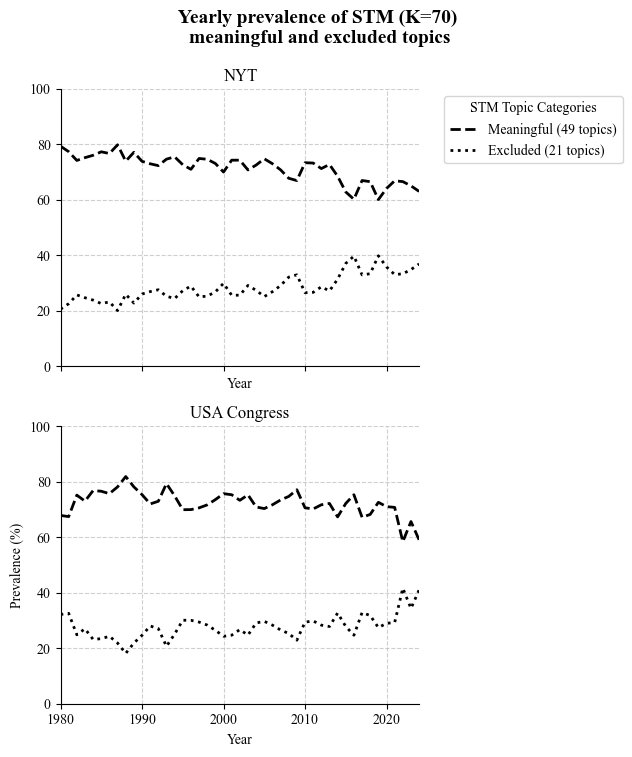

In [17]:
topics_list = ['horiz_inequalities',
 'macroeconomics',
 'stats_trends',
 'debt_housing',
 'businesses_corporations',
 'public_employment_nyc',
 'welfare_idiology',
 'civic_engagement',
 'health',
 'education',
 'international',
 'environment',
 'arts_entertainment',
 'sports'] #'boilerplate'
plot_topics_boilerplate_prevalence(topics_list, stm_nyt_df, stm_congress_df, window_size = 1, 
                                           df1_name="NYT", df2_name="USA Congress", output_path = "stm_meaning_prevalence_static.png")

##### Llama classification output to prevalences

In [18]:
#Import documents classifications Llama output (json format: {"topic": NUMBER, "subtopic": LETTER})
llama_coded = pd.read_csv("4_llama_codebook_cliff/llama_cliff_merged_2502.csv")
llama_errors = pd.read_csv("4_llama_codebook_cliff/llama_errors_merged_2502.csv")

In [19]:
llama_coded.head(2)

,id_,author,year,date,year_n,source,dataset,text,tokens_R,llama_cliff_4bit_2502_ordered
0,0,MARC F. PLATTNER; Marc F. Plattner is on the s...,1980,1980-06-08,1,nyt,nyt,WHO GETS WHAT THE ZERO-SUM SOCIETY Distributi...,get zero sum society distribution possibilitie...,"{""topic"": ""7"", ""subtopic"": ""A"", ""justification..."
1,1,ROBERT A. BENNETT,1980,1980-06-14,1,nyt,nyt,FED MONETARY POLICY:CREDIBILITY GAP; Economic ...,fed monetary policy credibility gap economic a...,"{""topic"": ""2"", ""subtopic"": ""C"", ""justification..."


In [20]:
#Map codebook llama answer to accordingly topics and subtopics
topic_mapping = {str(k): v["topic_name"] for k, v in codebook_to_tm.items()}

# Convert topic_mapping keys to integers
topic_mapping_int = {int(k): v for k, v in topic_mapping.items()}

In [21]:
def parse_llama_entry(entry):
    """
    Parses a JSON entry containing 'topic' and 'subtopic'.
    Ensures 'topic' is an integer and 'subtopic' is a valid string.
    
    Parameters:
    - entry (str): JSON string with 'topic' and 'subtopic'.
    
    Returns:
    - topic (int or None): Parsed topic number.
    - subtopic (str): Parsed subtopic letter or "none".
    """
    try:
        # Convert single quotes to double quotes to ensure valid JSON
        #entry = entry.replace("'", '"').replace('\\"', "'")
        
        # Load JSON data
        data = json.loads(entry)

        # Extract topic and subtopic
        topic = data.get("topic", None)
        subtopic = data.get("subtopic", "none")  # Default to "none" if missing

        # Ensure topic is an integer if possible
        topic = int(topic) if isinstance(topic, str) and topic.isdigit() else None

        # Ensure subtopic is a valid string
        subtopic = str(subtopic).strip() if subtopic else "none"

        return topic, subtopic

    except (json.JSONDecodeError, AttributeError, TypeError, ValueError):
        # Handle cases where JSON is invalid or missing
        return None, "none"


In [22]:
llama_coded[["topic", "subtopic"]] = llama_coded["llama_cliff_4bit_2502_ordered"].apply(lambda x: pd.Series(parse_llama_entry(x)))

In [23]:
# Map numeric topic to topic_name
llama_coded["topic_name"] = llama_coded["topic"].map(topic_mapping_int).fillna(np.nan)

llama_coded["subtopic_name"] = llama_coded.apply(
    lambda row: codebook_to_tm.get(int(row["topic"]), {}).get(row["subtopic"], {}).get("subtopic_name", np.nan)
    if pd.notnull(row["topic"]) else np.nan,
    axis=1
)


In [24]:
print("Llama classifications and NaN")
print()
print("topic values")
#print(llama_coded["topic"].value_counts())
print(llama_coded["topic"].isna().value_counts())
print()
print("topic name")
#print(llama_coded["topic_name"].value_counts())
print(llama_coded["topic_name"].isna().value_counts())
print()
print()
print()


print("subtopic values")
print(llama_coded["subtopic"].value_counts())
print(llama_coded["subtopic"].isna().value_counts())
print()
print("topic subtopic_name")
#print(llama_coded["subtopic_name"].value_counts())
print(llama_coded["subtopic_name"].isna().value_counts())


Llama classifications and NaN

topic values
topic
False    14148
True       310
Name: count, dtype: int64

topic name
topic_name
False    14148
True       310
Name: count, dtype: int64



subtopic values
subtopic
A       7066
B       3468
C       2427
D        901
none     596
Name: count, dtype: int64
subtopic
False    14458
Name: count, dtype: int64

topic subtopic_name
subtopic_name
False    13860
True       598
Name: count, dtype: int64


In [25]:
#598-310
598/len(llama_coded)

0.041361184119518606

In [26]:
llama_coded[(llama_coded["subtopic_name"].isna()) & (llama_coded["subtopic"] != "none")]
#A non existent subcategory

,id_,author,year,date,year_n,source,dataset,text,tokens_R,llama_cliff_4bit_2502_ordered,topic,subtopic,topic_name,subtopic_name
7101,8393,Matthew Phillips,2018,2018-08-22,39,nyt,nyt,"Bull Market Hits a Milestone: 3,453 Days. Most...",bull market hit milestone day americans party ...,"{""topic"": ""3"", ""subtopic"": ""C"", ""justification...",3.0,C,stats_trends,NaN
8820,11267,‘Sway’,2020,2020-11-19,41,nyt,nyt,Why 3rd Grade Matters President-Elect Joe Bid...,grade matters president elect joe biden daunti...,"{""topic"": ""3"", ""subtopic"": ""C"", ""justification...",3.0,C,stats_trends,NaN


In [27]:
llama_coded[llama_coded["subtopic"] == "none"]["topic"].value_counts()
#noisy, uses first category a lot

topic
1.0     230
13.0     15
9.0      11
11.0      8
10.0      5
2.0       5
14.0      4
7.0       3
6.0       2
12.0      1
4.0       1
8.0       1
Name: count, dtype: int64

Occurrences count per year

In [28]:
# Group by year, dataset and topic_name for analysis
llama_coded_filtered = llama_coded[~llama_coded["subtopic_name"].isna()]

grouped1 = (
    llama_coded_filtered.groupby(["year", "dataset", "topic_name"])
    .size()
    .unstack(fill_value=0)  # Pivot table with topic_names as columns
    .reset_index()
)

# Group by year, dataset and subtopic_name for analysis
grouped2 = (
    llama_coded_filtered.groupby(["year", "dataset", "subtopic_name"])
    .size()
    .unstack(fill_value=0)  # Pivot table with topic_names as columns
    .reset_index()
)

# Split df by dataset
llama_topic_nyt_count = grouped1[grouped1["dataset"] == "nyt"].drop(columns=["dataset"])
llama_topic_congress_count = grouped1[grouped1["dataset"] == "Congress"].drop(columns=["dataset"])
llama_subtopic_nyt_count = grouped2[grouped2["dataset"] == "nyt"].drop(columns=["dataset"])
llama_subtopic_congress_count  = grouped2[grouped2["dataset"] == "Congress"].drop(columns=["dataset"])

From counts to prevalence calculation

In [29]:
def calculate_prevalence(df):
    # Total sum per year (excluding 'year' column)
    sum_counts = df.drop(columns=["year"]).sum(axis=1)
    
    # Create a copy to preserve the original df
    df_prevalence = df.copy()
    
    # Divide each count column by the sum of counts for that year
    for col in df.columns:
        if col != "year":
            df_prevalence[col] = df[col] / sum_counts
    
    return df_prevalence

Merge topic and subtopic dfs for easier plotting

In [30]:
def merge_prevalence_datasets(df1, df2):
    # Apply calculate_prevalence
    df1_prevalence = calculate_prevalence(df1)
    df2_prevalence = calculate_prevalence(df2)
    
    # Merge the two datasets by 'year' (keeping only one 'year' column)
    merged_df = pd.merge(df1_prevalence, df2_prevalence, on="year", suffixes=("", "_df2"))
    #Note: some columns appear twice when topic only has one subtopic, handle better later
    
    return merged_df

In [31]:
# Llama prevalence and merge
llama_nyt_df = merge_prevalence_datasets(llama_topic_nyt_count, llama_subtopic_nyt_count)
llama_congress_df = merge_prevalence_datasets(llama_topic_congress_count, llama_subtopic_congress_count)

Llama internal validations

In [32]:
def extract_validation_samples(df, codebook_to_tm, topic_subtopic_pairs):
    """
    Extracts validation samples for classification model assessment.
    
    1. 100 random rows (50 from each dataset) on the first sheet.
    2. 20 random samples for each topic-subtopic pair (10 from each dataset), each in a separate sheet.
    
    Args:
    - df (DataFrame): The dataset containing classified data.
    - codebook_to_tm (dict): Mapping from topic numbers to topic names.
    - topic_subtopic_pairs (list of tuples): List of (topic, subtopic) pairs.
    
    Returns:
    - Saves two Excel files: one with topic/subtopic names and one without.
    """

    # Shuffle dataset
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    unnecesary_col = ["topic_name", "subtopic_name","date","year_n","source","tokens_R"]
    unnecesary_col2 = unnecesary_col+["llama_cliff_4bit_2502_ordered","topic","subtopic"]

    # Create Excel writer objects
    writer_with_topics = pd.ExcelWriter("validation_samples_with_topics.xlsx", engine="xlsxwriter")
    writer_without_topics = pd.ExcelWriter("validation_samples_without_topics.xlsx", engine="xlsxwriter")

    # Extract 100 random rows (50 from each dataset)
    sample_nyt = df[df["dataset"] == "nyt"].sample(n=50, random_state=42)
    sample_congress = df[df["dataset"] == "Congress"].sample(n=50, random_state=42)
    combined_sample = pd.concat([sample_nyt, sample_congress]).reset_index(drop=True)

    # Save to first sheet
    combined_sample.drop(columns=unnecesary_col).to_excel(writer_with_topics, sheet_name="Random Sample", index=False)
    combined_sample.drop(columns=unnecesary_col2).to_excel(writer_without_topics, sheet_name="Random Sample", index=False)

    # Extract 20 random cases per topic-subtopic pair (10 from each dataset)
    for topic, subtopic in topic_subtopic_pairs:
        # If subtopic is "-", select all instances of the topic regardless of subtopic
        if subtopic == "-":
            topic_subset = df[df["topic"] == topic]
        else:
            topic_subset = df[(df["topic"] == topic) & (df["subtopic"] == subtopic)]
        
        sample_nyt = topic_subset[topic_subset["dataset"] == "nyt"].sample(n=min(10, len(topic_subset[topic_subset["dataset"] == "nyt"])), random_state=42)
        sample_congress = topic_subset[topic_subset["dataset"] == "Congress"].sample(n=min(10, len(topic_subset[topic_subset["dataset"] == "Congress"])), random_state=42)
        topic_sample = pd.concat([sample_nyt, sample_congress]).reset_index(drop=True)

        # Define sheet name
        sheet_name = f"{topic}{subtopic}"

        # Save to respective Excel files
        topic_sample.drop(columns=unnecesary_col).to_excel(writer_with_topics, sheet_name=sheet_name, index=False)
        topic_sample.drop(columns=unnecesary_col2).to_excel(writer_without_topics, sheet_name=sheet_name, index=False)

    # Save and close files
    writer_with_topics.close()
    writer_without_topics.close()

    return "Validation samples saved as Excel files."

# Example usage

# Assuming `df` is your main dataset and `codebook_to_tm` contains the topic mappings
# extract_validation_samples(df, codebook_to_tm, topic_subtopic_pairs) # Uncomment when `df` is available

In [33]:
topic_subtopic_pairs = [(1, "-"),(1, "A"),(1, "B"),(2, "-"),(2, "B"),(3, "-"),(5, "-"),(7, "-"),(9, "-"),(9, "B"),(12, "-")]
extract_validation_samples(llama_coded, codebook_to_tm = codebook_to_tm, topic_subtopic_pairs = topic_subtopic_pairs)

'Validation samples saved as Excel files.'

External validations

In [34]:
def plot_topic_subtopics_validation(
    df1, df2, window_size=2, subtopics = None, topic_names = None, custom_labels=None, topic_groups =topic_groups,
    df1_name="Dataset 1", df2_name="Dataset 2", ymax=30, palette=None, output_path=None, suptitle = "TOPIC"):
    """
    Plot individual topic time series for multiple topic groups, side by side for two DataFrames,
    with a sliding window for smoothing.
    """
    # Combine all subtopics from the selected topic groups
    if topic_names:
        subtopic_columns = [sub for topic in topic_names for sub in topic_groups[topic].keys()]

    else:
        subtopic_columns = subtopics

    # Function to apply sliding window smoothing
    def apply_sliding_window(df, group_columns, window_size):
        return df[group_columns].rolling(window=window_size, min_periods=1).mean()

    # Apply the sliding window to both DataFrames
    df1_smoothed = apply_sliding_window(df1, subtopic_columns, window_size) * 100
    df2_smoothed = apply_sliding_window(df2, subtopic_columns, window_size) * 100

    
    # Create figure
    plt.rcParams['font.family'] = 'Times New Roman'
    fig, axes = plt.subplots(2, 1, figsize=(6.5, 8), sharex=True, sharey=True)

    line_styles = {'covid19': 'dotted', 'environment': 'dashed', 'taxes': 'solid'}
    color = "black"
    
    for subtopic in subtopic_columns:
        axes[0].plot(df1['year'], df1_smoothed[subtopic], label=f"{custom_labels.get(subtopic, subtopic)}" if custom_labels else subtopic, linestyle=line_styles[subtopic], color = "black",linewidth=2)
        axes[1].plot(df2['year'], df2_smoothed[subtopic], label=f"{custom_labels.get(subtopic, subtopic)}" if custom_labels else subtopic, linestyle=line_styles[subtopic], color = "black",linewidth=2)
    
    # Titles and labels
    axes[0].set_title(df1_name)
    axes[1].set_title(df2_name)
    
    axes[1].set_ylabel("Smoothed Prevalence (%)")
    axes[1].tick_params(axis='y', which='both', labelleft=True, labelright=False)
    events = {
        2020: "COVID-19"
    }
    for year, label in events.items():
        for ax in axes:
            ax.axvline(x=year, color='black', linestyle=(0, (3, 5)), linewidth=1, ymax=0.72)
            ax.text(year, 22, label, ha='center', fontsize=10)
            
    for year, label in events.items():
        axes[0].tick_params(axis='x', which='both', labelbottom=True)

    for ax in axes:
        ax.set_xlabel("Year")
        ax.set_xlim([df1['year'].min(), df1['year'].max()])
        ax.set_ylim([0, ymax])
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    axes[0].set_ylabel("Smoothed Prevalence (%)")

    # Reagan Presidency (1981-1989)
    for ax in axes:
        ax.axvline(x=1981, color='black', linestyle=(0, (3, 5)), linewidth=1, ymax=0.8)
        ax.axvline(x=1989, color='black', linestyle=(0, (3, 5)), linewidth=1, ymax=0.8)
        ax.text(1985, 22, "Reagan", ha='center', fontsize=10)#, fontweight='bold')
        #ax.axvline(x=start, color='black', linestyle=(0, (3, 5)), linewidth=1, ymax=0.8)
        #ax.text((start + end) / 2, 2.1, name, color=party_colors[party], ha='center', fontsize=9)#, fontweight='bold')
    
    # Legend
    axes[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Subtopics")
    
    # Main title
    fig.suptitle(f"{suptitle}\n(smoothing sliding window = {window_size})", fontsize=14, fontweight='bold', y=0.94)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save or show plot
    if output_path:
        output_path = "graphs/"+ output_path
        plt.savefig(output_path, bbox_inches='tight')
    plt.show()


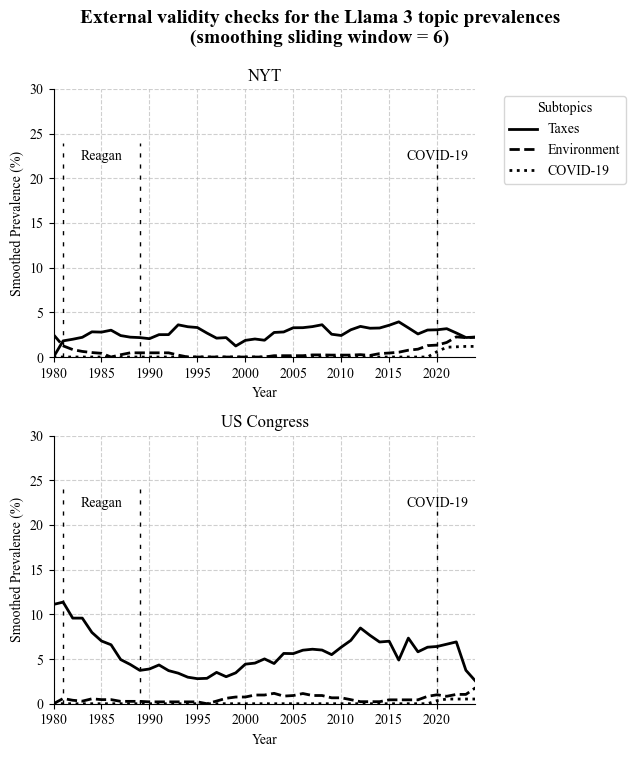

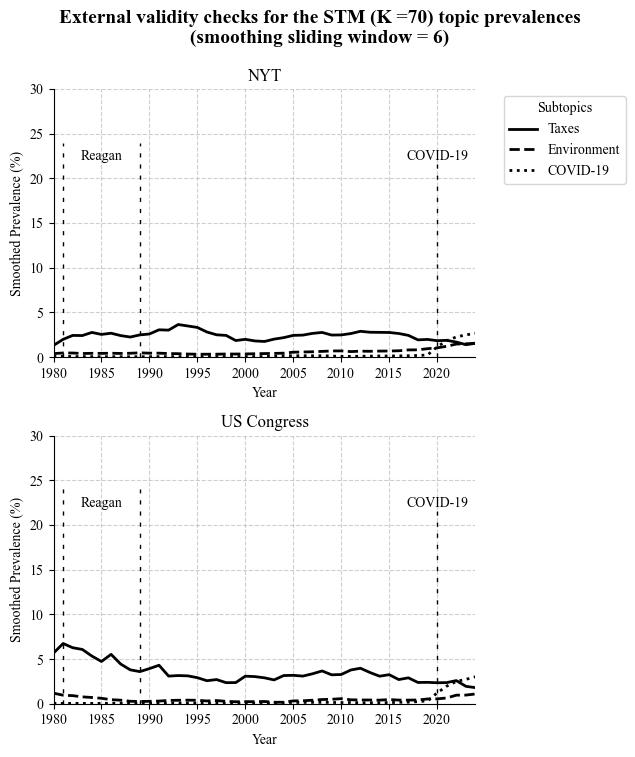

In [35]:
econ_subtopics = ["taxes", "environment","covid19"]
window_size = 6         
ymax = 30
df1_name = "NYT"
df2_name = "US Congress"

custom_labels_valid = {
    "covid19": "COVID-19",
    "taxes": "Taxes",
    "environment": "Environment"}

#plot_topic_subtopics_static(stm_nyt_df, stm_congress_df, custom_labels=custom_labels_valid, subtopics = econ_subtopics, topic_groups = topic_groups, 
#                     window_size=window_size, df1_name=df1_name, df2_name=df2_name, ymax = ymax, palette=palette,
#                     suptitle = "External validity checks for the STM topic prevalences", output_path= "validation_prevalence_stm.png")

plot_topic_subtopics_validation(llama_nyt_df, llama_congress_df, custom_labels=custom_labels_valid, subtopics = econ_subtopics, topic_groups = topic_groups, 
                     window_size=window_size, df1_name=df1_name, df2_name=df2_name, ymax = ymax,
                     suptitle = "External validity checks for the Llama 3 topic prevalences", output_path= "validation_prevalence_llama.png")

plot_topic_subtopics_validation(stm_nyt_df, stm_congress_df, custom_labels=custom_labels_valid, subtopics = econ_subtopics, topic_groups = topic_groups, 
                     window_size=window_size, df1_name=df1_name, df2_name=df2_name, ymax = ymax,
                     suptitle = "External validity checks for the STM (K =70) topic prevalences", output_path= "validation_prevalence_stm.png")


Static Graphs

In [36]:
def plot_topics_static(df1, df2, cliff_name, topics_list, custom_labels, ymax=30, window_size=2, df1_name="Dataset 1", df2_name="Dataset 2", output_path=None):
    """
    Create a static Matplotlib plot for grouped topic time series with a sliding window.
    
    Parameters:
    - df1, df2: DataFrames containing time series data.
    - topics_list: List of group names to plot.
    - window_size: Size of the sliding window (default is 2 years).
    - df1_name, df2_name: Titles for the two datasets.
    - output_path: Optional file path to save the plot.
    """
    plt.rcParams['font.family'] = 'Times New Roman'

    # Function to apply the sliding window
    def apply_sliding_window(df, window_size):
        return df[topics_list].rolling(window=window_size, min_periods=1).mean()

    # Apply smoothing
    df1_smoothed = apply_sliding_window(df1, window_size) * 100
    df2_smoothed = apply_sliding_window(df2, window_size) * 100

    # Define colors
    colors = ["darkred", "steelblue", "forestgreen", "purple", "gray", "sienna", "steelblue", 
               "goldenrod", "hotpink", "limegreen", "crimson", "rosybrown"]
    num_colors = len(colors)

    # Create figure
    #fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    fig, axes = plt.subplots(2, 1, figsize=(6.5, 8), sharey=True)
        # Create figure
    # Create figure with size based on LaTeX's linewidth
    #fig_width_inch = 6.5  # Typical figure width for LaTeX
    #fig_height_inch = 4   # Adjust to maintain aspect ratio
    #fig, ax = plt.subplots(figsize=(fig_width_inch, fig_height_inch))
    
    for idx, topic in enumerate(topics_list):
        color = colors[idx % num_colors]
        
        # Plot for df1
        #axes[0].plot(df1['year'], df1_smoothed[topic], label=topic, color=color, linewidth=2)
        axes[0].plot(df1['year'], df1_smoothed[topic], label=f"{custom_labels.get(topic, topic)}", color=color, linewidth=2)
        
        # Plot for df2
        #axes[1].plot(df2['year'], df2_smoothed[topic], label = topic, color=color, linewidth=2)
        axes[1].plot(df2['year'], df2_smoothed[topic], label=f"{custom_labels.get(topic, topic)}", color=color, linewidth=2)
    
    # Titles and labels
    axes[0].set_title(df1_name)
    axes[1].set_title(df2_name)
    
    axes[1].set_ylabel("Smoothed Prevalence (%)")
    axes[1].yaxis.set_visible(True)
    axes[1].tick_params(axis='y', which='both', labelleft=True, labelright=False)

    for ax in axes:
        ax.set_xlabel("Year")
        ax.yaxis.set_visible(True)
        ax.set_xlim([df1['year'].min(), df1['year'].max()])
        ax.set_ylim([0, ymax])
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        events = {
        2007: "GR",
        2011: "OWS",
        2020: "COVID-19"}

    for year, label in events.items():
        for ax in axes:
            ax.axvline(x=year, color='black', linestyle='dotted', linewidth=1.5, ymax=0.87)
            ax.text(year, ymax * 0.9, label, ha='center', fontsize=10)#, fontweight='bold')
    
    axes[0].set_ylabel("Smoothed Prevalence (%)")
    
    # Legend
    axes[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Topics")
    
    # Main title
    fig.suptitle(f"Topics yearly prevalence [{cliff_name}]\n(smoothing sliding window = {window_size})", fontsize=14, fontweight='bold', y=0.94)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save or show plot
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
    plt.show()

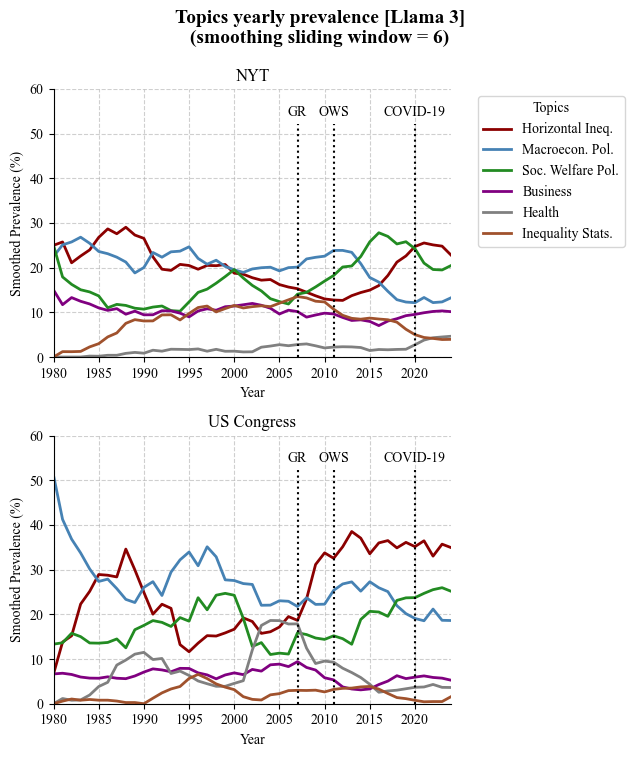

In [37]:
topics_list = ['horiz_inequalities', 'macroeconomics', "welfare_idiology", 'businesses_corporations', 'health', 'stats_trends']#, 

custom_labels = {
    "horiz_inequalities": "Horizontal Ineq.",
    "macroeconomics": "Macroecon. Pol.",
    "welfare_idiology": "Soc. Welfare Pol.",
    "businesses_corporations": "Business",
    "health": "Health",
    "stats_trends": "Inequality Stats."
    # Add all topic names with their corresponding custom labels
}

window_size = 6
df1_name="NYT"
df2_name="US Congress"
ymax = 60

plot_topics_static(llama_nyt_df, llama_congress_df, cliff_name = "Llama 3", topics_list = topics_list, custom_labels= custom_labels,window_size=window_size, df1_name=df1_name, df2_name=df2_name, ymax = ymax, output_path= "graphs/llama_topic_prevalence_static.png")

In [38]:
def pearsonr_ci_with_p(x, y, alpha=0.05):
    r, p = pearsonr(x, y)
    n = len(x)
    if n < 4:
        return r, np.nan, np.nan, p
    z = 0.5 * np.log((1 + r) / (1 - r))
    se = 1 / np.sqrt(n - 3)
    z_crit = norm.ppf(1 - alpha / 2)
    z_lower = z - z_crit * se
    z_upper = z + z_crit * se
    ci_lower = np.tanh(z_lower)
    ci_upper = np.tanh(z_upper)
    return r, ci_lower, ci_upper, p

def smoothed_corr_by_period(df, variables, pivot_year=2011, window_size=6, alpha=0.05):
    results = []
    
    df = df.copy()

    # Split into early and late periods
    df_early = df[(df["year"] >= 1980) & (df["year"] < pivot_year)].copy()
    df_late = df[(df["year"] >= pivot_year) & (df["year"] <= 2024)].copy()

    for var in variables:
        for period_name, period_df in [(
            f"1980–{pivot_year-1}", df_early), (f"{pivot_year}–2024", df_late)]:
            
            temp_df = period_df[["year", var]].dropna().copy()
            temp_df[var] = temp_df[var].rolling(window=window_size, min_periods=1).mean()
            temp_df = temp_df.dropna()

            if len(temp_df) >= 4:
                r, ci_low, ci_high, p = pearsonr_ci_with_p(temp_df["year"], temp_df[var], alpha)
            else:
                r, ci_low, ci_high, p = np.nan, np.nan, np.nan, np.nan

            results.append({
                "Variable": var,
                "Period": period_name,
                "r": round(r, 3),
                "95% CI Lower": round(ci_low, 3),
                "95% CI Upper": round(ci_high, 3),
                "p-value": round(p, 4)
            })

    return pd.DataFrame(results)


In [39]:
def smoothed_cross_correlations(df, variables, window_size=6, alpha=0.05):
    # Apply smoothing
    smoothed_df = df[["year"] + variables].copy()
    for var in variables:
        smoothed_df[var] = smoothed_df[var].rolling(window=window_size, min_periods=1).mean()

    # Calculate pairwise correlations with CIs and p-values
    pairwise_results = []
    for var1, var2 in combinations(variables, 2):
        df_pair = smoothed_df[[var1, var2]].dropna()
        r, p = pearsonr(df_pair[var1], df_pair[var2])

        n = len(df_pair)
        if n > 3:
            z = 0.5 * np.log((1 + r) / (1 - r))
            se = 1 / np.sqrt(n - 3)
            z_crit = norm.ppf(1 - alpha / 2)
            z_lower = z - z_crit * se
            z_upper = z + z_crit * se
            ci_lower = np.tanh(z_lower)
            ci_upper = np.tanh(z_upper)
        else:
            ci_lower, ci_upper = np.nan, np.nan

        pairwise_results.append({
            "Var1": var1,
            "Var2": var2,
            "r": round(r, 3),
            "95% CI Lower": round(ci_lower, 3),
            "95% CI Upper": round(ci_upper, 3),
            "p-value": round(p, 4)
        })

    return pd.DataFrame(pairwise_results)


In [40]:
def smoothed_corr_whole_period(df, variables, window_size=6, alpha=0.05):
    results = []
    df = df.copy()

    for var in variables:
        temp_df = df[["year", var]].dropna().copy()
        temp_df[var] = temp_df[var].rolling(window=window_size, min_periods=1).mean()
        temp_df = temp_df.dropna()

        if len(temp_df) >= 4:
            r, ci_low, ci_high, p = pearsonr_ci_with_p(temp_df["year"], temp_df[var], alpha)
        else:
            r, ci_low, ci_high, p = np.nan, np.nan, np.nan, np.nan

        results.append({
            "Variable": var,
            "r": round(r, 3),
            "95% CI Lower": round(ci_low, 3),
            "95% CI Upper": round(ci_high, 3),
            "p-value": round(p, 4)
        })

    return pd.DataFrame(results)

In [41]:
variables = ["horiz_inequalities"]#, "macroeconomics", "welfare_idiology"]
results_df = smoothed_corr_whole_period(llama_nyt_df, variables, window_size=6)
results_df2 = smoothed_corr_whole_period(stm_nyt_df, variables, window_size=6)

print(results_df)
print(results_df2)

             Variable      r  95% CI Lower  95% CI Upper  p-value
0  horiz_inequalities -0.428        -0.641        -0.153   0.0034
             Variable      r  95% CI Lower  95% CI Upper  p-value
0  horiz_inequalities -0.405        -0.624        -0.126   0.0058


In [42]:
variables = ["horiz_inequalities"]#, "macroeconomics", "welfare_idiology"]
results_df = smoothed_corr_whole_period(llama_congress_df, variables, window_size=6)
results_df2 = smoothed_corr_whole_period(stm_congress_df, variables, window_size=6)
print(results_df)
print(results_df2)

             Variable      r  95% CI Lower  95% CI Upper  p-value
0  horiz_inequalities  0.625         0.406         0.776      0.0
             Variable      r  95% CI Lower  95% CI Upper  p-value
0  horiz_inequalities  0.698         0.509         0.823      0.0


In [43]:
variables = ["horiz_inequalities", "macroeconomics", "welfare_idiology"]
results_df = smoothed_corr_by_period(llama_nyt_df, variables, pivot_year=2011)
print(results_df)

             Variable     Period      r  95% CI Lower  95% CI Upper  p-value
0  horiz_inequalities  1980–2010 -0.868        -0.935        -0.742   0.0000
1  horiz_inequalities  2011–2024  0.942         0.821         0.982   0.0000
2      macroeconomics  1980–2010 -0.596        -0.784        -0.306   0.0004
3      macroeconomics  2011–2024 -0.901        -0.969        -0.710   0.0000
4    welfare_idiology  1980–2010 -0.016        -0.368         0.340   0.9326
5    welfare_idiology  2011–2024 -0.555        -0.839        -0.034   0.0394


In [44]:
variables = ["horiz_inequalities", "macroeconomics", "welfare_idiology"]
pairwise_results_df = smoothed_cross_correlations(llama_nyt_df, variables, window_size=6)
print(pairwise_results_df)

                 Var1              Var2      r  95% CI Lower  95% CI Upper  \
0  horiz_inequalities    macroeconomics -0.142        -0.418         0.158   
1  horiz_inequalities  welfare_idiology -0.197        -0.464         0.102   
2      macroeconomics  welfare_idiology -0.567        -0.738        -0.329   

   p-value  
0   0.3514  
1   0.1937  
2   0.0000  


STM Lla correlation for horizontal ienqualities

In [45]:
# Format as table
def format_corr_ci(r, low, high):
    return f"{r:.2f} ({low:.2f}, {high:.2f})"

# Redefine the STM vs LLM comparison to use pearsonr_ci_with_p
def compare_stm_llm_with_ci_and_p(df_stm, df_llm, topic_name, window_size=6):
    # Smooth both datasets
    stm = df_stm[["year", topic_name]].copy()
    llm = df_llm[["year", topic_name]].copy()
    stm[topic_name] = stm[topic_name].rolling(window=window_size, min_periods=1).mean()
    llm[topic_name] = llm[topic_name].rolling(window=window_size, min_periods=1).mean()

    # Merge on year
    merged = pd.merge(stm, llm, on="year", suffixes=("_stm", "_llm")).dropna()
    r, ci_low, ci_high, p_value = pearsonr_ci_with_p(merged[f"{topic_name}_stm"], merged[f"{topic_name}_llm"])
    return format_corr_ci(r, ci_low, ci_high), p_value

# Build updated table
stm_llm_corr_updated = {
    "": ["NYT", "Congress"],
    "STM vs. LLM Correlation (r and 95% CI)": [],
    "p-value": []
}

# Apply updated function
for df1, df2 in [(stm_nyt_df, llama_nyt_df), (stm_congress_df, llama_congress_df)]:
    corr_ci, p_val = compare_stm_llm_with_ci_and_p(df1, df2, "horiz_inequalities")
    stm_llm_corr_updated["STM vs. LLM Correlation (r and 95% CI)"].append(corr_ci)
    stm_llm_corr_updated["p-value"].append(p_val)

stm_llm_corr_table_updated = pd.DataFrame(stm_llm_corr_updated)
stm_llm_corr_table_updated

,,STM vs. LLM Correlation (r and 95% CI),p-value
0,NYT,"0.98 (0.96, 0.99)",6.638832e-31
1,Congress,"0.96 (0.92, 0.98)",6.619642e-25


In [46]:
variables = ["horiz_inequalities", "macroeconomics", "welfare_idiology"]
results_df = smoothed_corr_by_period(llama_congress_df, variables, pivot_year=2008)
print(results_df)

             Variable     Period      r  95% CI Lower  95% CI Upper  p-value
0  horiz_inequalities  1980–2007 -0.263        -0.579         0.122   0.1760
1  horiz_inequalities  2008–2024 -0.740        -0.900        -0.403   0.0007
2      macroeconomics  1980–2007 -0.587        -0.788        -0.274   0.0010
3      macroeconomics  2008–2024 -0.582        -0.830        -0.141   0.0142
4    welfare_idiology  1980–2007  0.149        -0.238         0.494   0.4501
5    welfare_idiology  2008–2024  0.950         0.865         0.982   0.0000


In [47]:
variables = ["horiz_inequalities", "macroeconomics", "welfare_idiology"]
pairwise_results_df = smoothed_cross_correlations(llama_congress_df, variables, window_size=6)
print(pairwise_results_df)

                 Var1              Var2      r  95% CI Lower  95% CI Upper  \
0  horiz_inequalities    macroeconomics -0.638        -0.785        -0.424   
1  horiz_inequalities  welfare_idiology  0.208        -0.091         0.473   
2      macroeconomics  welfare_idiology -0.225        -0.486         0.074   

   p-value  
0   0.0000  
1   0.1695  
2   0.1377  


In [48]:
def plot_gap_boxplot(df, col_name="gap", year_col="year", pivot_year=2014,
                     title="Differences in coverage", y_label="Gap",
                     output_path="gap_difference_boxplot.png"):
    """
    Create a boxplot comparing values before and after a pivot year,
    including mean markers and annotated outliers.

    Parameters:
        df (pd.DataFrame): The input dataframe with a year column and a variable to compare.
        col_name (str): Column name for the variable to compare (e.g., 'gap').
        year_col (str): Column name representing the year.
        pivot_year (int): The year to split the data (default: 2014).
        title (str): Title of the plot.
        y_label (str): Y-axis label.
        output_path (str): File path to save the plot as PNG.
    """

    # Set font
    plt.rcParams['font.family'] = 'Times New Roman'

    # Create figure
    fig, ax = plt.subplots(figsize=(6.5, 4))

    # Subset and clean data
    before = df[df[year_col] <= pivot_year][[year_col, col_name]].dropna()
    after = df[df[year_col] > pivot_year][[year_col, col_name]].dropna()

    # Calculate means
    mean_before = before[col_name].mean()
    mean_after = after[col_name].mean()

    # Boxplot data
    data = [before[col_name], after[col_name]]
    labels = [f"1980–{pivot_year}", f"{pivot_year+1}–2024"]

    # Create boxplot
    ax.boxplot(data, labels=labels,
               flierprops=dict(marker='o', color='black', markersize=6),
               medianprops=dict(color='black', linewidth=1))

    # Annotate outliers with year
    for i, group in enumerate([before, after], start=1):
        q1 = group[col_name].quantile(0.25)
        q3 = group[col_name].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = group[(group[col_name] < lower_bound) | (group[col_name] > upper_bound)]
        for _, row in outliers.iterrows():
            ax.text(i + 0.05, row[col_name], str(int(row[year_col])),
                    fontsize=9, color="black", va='center')

    # Plot mean markers
    ax.plot(1, mean_before, 'ko', markersize=4)
    ax.plot(2, mean_after, 'ko', markersize=4)

    # Decorate
    ax.set_title(title, pad=15)
    ax.set_ylabel(y_label)
    ax.grid(True, axis='y')
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()


In [49]:
def analyze_gap_statistics(df, col_name="gap", year_col="year", pivot_year=2014):
    """
    Performs t-tests, confidence intervals, and Cohen's d on a gap variable
    split before and after a pivot year.

    Parameters:
        df (pd.DataFrame): Input DataFrame with a year column and a gap column.
        col_name (str): Name of the column to analyze.
        year_col (str): Name of the column with year values.
        pivot_year (int): Year that divides the two periods.
    """

    before = df[df[year_col] <= pivot_year][col_name].dropna()
    after = df[df[year_col] > pivot_year][col_name].dropna()

    # --- One-sample t-tests (test if mean ≠ 0) ---
    print("One-sample t-tests (test if mean ≠ 0):")
    t_b, p_b = ttest_1samp(before, popmean=0)
    t_a, p_a = ttest_1samp(after, popmean=0)
    print(f"  Before {pivot_year}: t = {t_b:.2f}, p = {p_b:.4f}")
    print(f"  After {pivot_year}:  t = {t_a:.2f}, p = {p_a:.4f}\n")

    # --- Two-sample Welch’s t-test ---
    t_stat, p_val = ttest_ind(before, after, equal_var=False)
    mean_diff = before.mean() - after.mean()
    se_diff = np.sqrt(before.var(ddof=1)/len(before) + after.var(ddof=1)/len(after))

    n1, n2 = len(before), len(after)
    df_welch = (before.var(ddof=1)/n1 + after.var(ddof=1)/n2)**2 / \
               ((before.var(ddof=1)**2)/((n1**2)*(n1-1)) + (after.var(ddof=1)**2)/((n2**2)*(n2-1)))

    ci_range = t.ppf(0.975, df_welch) * se_diff
    ci_low, ci_high = mean_diff - ci_range, mean_diff + ci_range

    print("Two-sample Welch t-test:")
    print(f"  t = {t_stat:.2f}, p = {p_val:.4f}")
    print(f"  Mean diff = {mean_diff:.2f} (95% CI: {ci_low:.2f}, {ci_high:.2f})\n")

    # --- Confidence intervals for each group ---
    def mean_ci(data, conf=0.95):
        n = len(data)
        mean = np.mean(data)
        se = np.std(data, ddof=1) / np.sqrt(n)
        t_crit = t.ppf((1 + conf) / 2, df=n - 1)
        return mean, mean - t_crit * se, mean + t_crit * se

    m_b, ci_b_low, ci_b_high = mean_ci(before)
    m_a, ci_a_low, ci_a_high = mean_ci(after)

    print("Confidence intervals for group means:")
    print(f"  Before {pivot_year}: Mean = {m_b:.2f}, 95% CI = [{ci_b_low:.2f}, {ci_b_high:.2f}]")
    print(f"  After {pivot_year}:  Mean = {m_a:.2f}, 95% CI = [{ci_a_low:.2f}, {ci_a_high:.2f}]\n")

    # --- Cohen's d ---
    pooled_sd = np.sqrt(((n1 - 1)*np.var(before, ddof=1) + (n2 - 1)*np.var(after, ddof=1)) / (n1 + n2 - 2))
    cohen_d = mean_diff / pooled_sd
    print(f"Cohen's d: {cohen_d:.3f}")

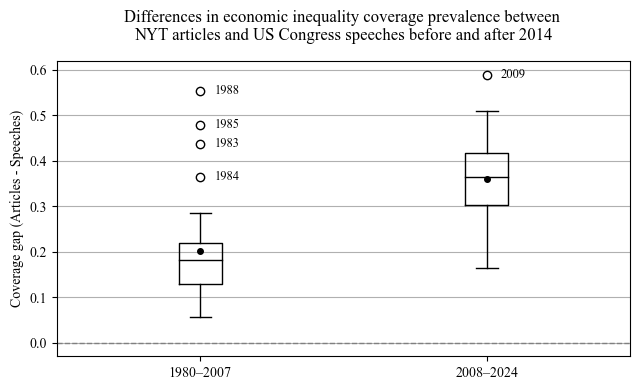

In [50]:
plot_gap_boxplot(
    df=llama_congress_df,
    col_name="horiz_inequalities",
    pivot_year=2007,
    title="Differences in economic inequality coverage prevalence between \nNYT articles and US Congress speeches before and after 2014",
    y_label="Coverage gap (Articles - Speeches)",
    output_path="graphs/congress_horizontal_inequality_boxplot.png"
)


In [51]:
analyze_gap_statistics(llama_congress_df, col_name="horiz_inequalities", year_col="year", pivot_year=2007)

One-sample t-tests (test if mean ≠ 0):
  Before 2007: t = 8.58, p = 0.0000
  After 2007:  t = 13.82, p = 0.0000

Two-sample Welch t-test:
  t = -4.51, p = 0.0001
  Mean diff = -0.16 (95% CI: -0.23, -0.09)

Confidence intervals for group means:
  Before 2007: Mean = 0.20, 95% CI = [0.15, 0.25]
  After 2007:  Mean = 0.36, 95% CI = [0.31, 0.42]

Cohen's d: -1.338


Subtopics

In [52]:
# Function to compute bootstrap CI lines per subtopic and dataset
def compute_bootstrap_ci_lines(llama_coded, dataset_name, subtopics, years, window_size=6, n_boot=1000, ci=95):
    ci_results = {sub: {"lower": [], "upper": []} for sub in subtopics}
    
    for year in tqdm(years, desc=f"Bootstrapping for {dataset_name}"):
        #subset year
        year_data = llama_coded[(llama_coded["dataset"] == dataset_name) & 
                                (llama_coded["year"] == year)]

        boot_props = {sub: [] for sub in subtopics}

        #do this for the amount of bootstraps
        for _ in range(n_boot):
            #sample with replacement the total amount of data
            boot_sample = year_data.sample(frac=1, replace=True)
            total = len(boot_sample)

            #calculate proportion for all subtopics and add to boot_props[sub]
            for sub in subtopics:
                count = (boot_sample["subtopic_name"] == sub).sum()
                boot_props[sub].append(count / total * 100)

        #calculate years CI95% upper and lower bounds
        for sub in subtopics:
            lower = np.percentile(boot_props[sub], (100 - ci) / 2)
            upper = np.percentile(boot_props[sub], 100 - (100 - ci) / 2)
            ci_results[sub]["lower"].append(lower)
            ci_results[sub]["upper"].append(upper)

    # Apply sliding window smoothing
    smoothed = {}
    for sub in subtopics:
        lower_series = pd.Series(ci_results[sub]["lower"]).rolling(window=window_size, min_periods=1).mean()
        upper_series = pd.Series(ci_results[sub]["upper"]).rolling(window=window_size, min_periods=1).mean()
        smoothed[sub] = {
            "lower": lower_series.values,
            "upper": upper_series.values
        }

    return smoothed, years

In [53]:
# Run computation for relevant subtopics
subtopics = ["gender", "race"]

smoothed_ci_lines_nyt, years = compute_bootstrap_ci_lines(
    llama_coded=llama_coded,
    dataset_name="nyt",
    subtopics=subtopics,
    years=np.arange(1980, 2025),
    window_size=6,
    n_boot=1000,  
    ci=95
)

smoothed_ci_lines_congress, years = compute_bootstrap_ci_lines(
    llama_coded=llama_coded,
    dataset_name="Congress",
    subtopics=subtopics,
    years=np.arange(1980, 2025),
    window_size=6,
    n_boot=1000, 
    ci=95
)

Bootstrapping for Congress: 100%|██████████| 45/45 [00:20<00:00,  2.23it/s]


In [54]:
# Modified version of the plotting function to include CI ribbons
def plot_topic_subtopics_static_with_ci(
    df1, df2, smoothed_ci_lines_df1, smoothed_ci_lines_df2, years, window_size=6,
    subtopics=None, topic_names=None, custom_labels=None, topic_groups=None,
    df1_name="Dataset 1", df2_name="Dataset 2", ymax=45, palette=None,
    output_path=None, suptitle="TOPIC"
):
    # Combine all subtopics from the selected topic groups
    if topic_names:
        subtopic_columns = [sub for topic in topic_names for sub in topic_groups[topic].keys()]
    else:
        subtopic_columns = subtopics

    # Function to apply sliding window smoothing
    def apply_sliding_window(df, group_columns, window_size):
        return df[group_columns].rolling(window=window_size, min_periods=1).mean()

    # Apply the sliding window to both DataFrames
    df1_smoothed = apply_sliding_window(df1, subtopic_columns, window_size) * 100
    df2_smoothed = apply_sliding_window(df2, subtopic_columns, window_size) * 100

    if palette is None:
        palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
    colors = palette[:len(subtopic_columns)]
    color_map = {sub: colors[i % len(colors)] for i, sub in enumerate(subtopic_columns)}

    # Create figure
    plt.rcParams['font.family'] = 'Times New Roman'
    fig, axes = plt.subplots(2, 1, figsize=(6.5, 8), sharex=True, sharey=True)

    for sub in subtopic_columns:
        # Plot main line
        axes[0].plot(df1["year"], df1_smoothed[sub], label=custom_labels.get(sub, sub) if custom_labels else sub, color=color_map[sub], linewidth=2)
        axes[1].plot(df2["year"], df2_smoothed[sub], label=custom_labels.get(sub, sub) if custom_labels else sub, color=color_map[sub], linewidth=2)

        # Plot CIs from precomputed smoothed_ci_lines
        axes[0].plot(years, smoothed_ci_lines_df1[sub]["lower"], linestyle="--", color=color_map[sub], linewidth=1)
        axes[0].plot(years, smoothed_ci_lines_df1[sub]["upper"], linestyle="--", color=color_map[sub], linewidth=1)
        axes[1].plot(years, smoothed_ci_lines_df2[sub]["lower"], linestyle="--", color=color_map[sub], linewidth=1)
        axes[1].plot(years, smoothed_ci_lines_df2[sub]["upper"], linestyle="--", color=color_map[sub], linewidth=1)

    axes[0].set_title(df1_name)
    axes[1].set_title(df2_name)
    axes[1].set_ylabel("Smoothed Prevalence (%)")
    axes[1].tick_params(axis='y', which='both', labelleft=True, labelright=False)

    events = {2007: "GR", 2011: "OWS", 2020: "COVID-19"}
    for year, label in events.items():
        for ax in axes:
            ax.axvline(x=year, color='black', linestyle='dotted', linewidth=1.5, ymax=0.87)
            ax.text(year, ymax * 0.9, label, ha='center', fontsize=10)

    for ax in axes:
        ax.set_xlabel("Year")
        ax.set_xlim([df1['year'].min(), df1['year'].max()])
        ax.set_ylim([0, ymax])
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    axes[0].set_ylabel("Smoothed Prevalence (%)")
    axes[0].tick_params(axis='x', labelbottom=True)
    axes[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Subtopics")
    fig.suptitle(f"{suptitle}\n(smoothing sliding window = {window_size})", fontsize=14, fontweight='bold', y=0.94)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if output_path:
        output_path = "graphs/" + output_path
        plt.savefig(output_path, bbox_inches='tight')
    plt.show()


In [55]:
#HI colors

# Extract the last three colors from the YlOrBr palette
ylorbr_colors = sns.color_palette("YlOrBr", as_cmap=False)
last_three_colors = ylorbr_colors[-3:]

# Convert to hex values
hi_colors = list(reversed([mcolors.to_hex(color) for color in last_three_colors]))

custom_labels_hi = {
    "gender": "Gender",
    "race": "Race",
    "affirmative_action": "Affirmative Action"}

topic_groups["horiz_inequalities"].keys()

dict_keys(['gender', 'race', 'affirmative_action'])

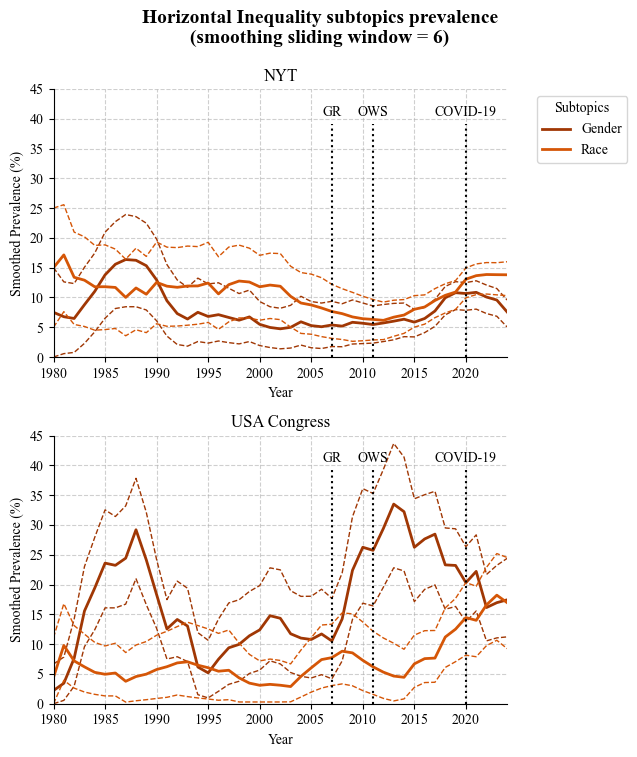

In [56]:
plot_topic_subtopics_static_with_ci(
    df1=llama_nyt_df,  # your NYT data with 'year' and subtopic cols
    df2=llama_congress_df,  # your Congress data
    smoothed_ci_lines_df1=smoothed_ci_lines_nyt,  # from your bootstrap results
    smoothed_ci_lines_df2=smoothed_ci_lines_congress,
    years=np.arange(1980, 2025),  # or whatever year range you used
    subtopics=["gender", "race"],
    palette=hi_colors,
    custom_labels={"gender": "Gender", "race": "Race"},
    df1_name="NYT",
    df2_name="USA Congress",
    suptitle="Horizontal Inequality subtopics prevalence",
    output_path="hi_subtopics_bootstrap_ci.png"
)


In [57]:
variables = ["gender", "race"]
results_df = smoothed_corr_by_period(llama_nyt_df, variables, pivot_year=2011)
print(results_df)

  Variable     Period      r  95% CI Lower  95% CI Upper  p-value
0   gender  1980–2010 -0.612        -0.794        -0.329   0.0003
1   gender  2011–2024  0.823         0.518         0.942   0.0003
2     race  1980–2010 -0.778        -0.888        -0.585   0.0000
3     race  2011–2024  0.971         0.907         0.991   0.0000


In [58]:
variables = ["gender", "race"]
results_df = smoothed_corr_by_period(llama_congress_df, variables, pivot_year=2011)
print(results_df)

  Variable     Period      r  95% CI Lower  95% CI Upper  p-value
0   gender  1980–2010  0.007        -0.348         0.361   0.9684
1   gender  2011–2024 -0.232        -0.679         0.340   0.4239
2     race  1980–2010  0.064        -0.297         0.409   0.7323
3     race  2011–2024  0.971         0.908         0.991   0.0000


#### Dynamic Visualizations

##### Visualization functions

Topics visualization as in codebook (for STM and Llama dfs)

In [59]:
def plot_topics(df1, df2, cliff_name, topics_list, ymax = 30, window_size=2, df1_name="Dataset 1", df2_name="Dataset 2", output_path=None):
    """
    Create an interactive Plotly plot for grouped topic time series with linked hover effects.

    Parameters:
    - topics_list (list): List of group names to plot.
    - df1 (pd.DataFrame): First DataFrame containing time series data.
    - df2 (pd.DataFrame): Second DataFrame containing time series data.
    - window_size (int): Size of the sliding window (default is 2 years).
    - df1_name (str): Title for the first DataFrame's plot.
    - df2_name (str): Title for the second DataFrame's plot.
    """
    # Function to apply the sliding window
    def apply_sliding_window(df, window_size):
        return df[topics_list].rolling(window=window_size, min_periods=1).mean()

    # Apply the sliding window to both DataFrames
    df1_smoothed = apply_sliding_window(df1, window_size) * 100  # Multiply by 100 to convert to percentage
    df2_smoothed = apply_sliding_window(df2, window_size) * 100  # Multiply by 100 to convert to percentage


    # Define less bright colors for the lines
    colors = ["darkred", "darkorange", "forestgreen", "purple", "gray", "sienna", "steelblue", 
               "goldenrod", "hotpink", "limegreen", "crimson", "rosybrown"] #"teal","indigo", "navy"
    
    num_colors = len(colors)

    # Create subplots
    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=[df1_name, df2_name],
        shared_yaxes=False  # Ensure y-axes are synchronized
    )

    # Add traces for both DataFrames
    for idx, group_name in enumerate(topics_list):
        color = colors[idx % num_colors]  # Cycle through the color list

        visibility = True if idx < 4 else "legendonly"
        # Trace for df1
        fig.add_trace(
            go.Scatter(
                x=df1['year'],
                y=df1_smoothed[group_name],
                mode='lines',
                name=group_name,
                hoverinfo="x+y+name",
                legendgroup=group_name,  # Link traces with the same name across graphs
                hovertemplate="%{y:.1f}%",  # 4 decimals
                line=dict(width=3, color=color),
                visible = visibility
            ),
            row=1,
            col=1,
        )

        # Trace for df2 
        fig.add_trace(
            go.Scatter(
                x=df2['year'],
                y=df2_smoothed[group_name],
                mode='lines',
                name=group_name,
                hovertemplate="%{y:.1f}%",
                hoverinfo="x+y+name",
                legendgroup=group_name,  # Link traces with the same name across graphs
                line=dict(width=3, color=color),  # Dashed line to differentiate datasets
                showlegend=False,  # Do not show legend again
                visible=visibility
            ),
            row=1,
            col=2,
        )

    # Update layout for titles, axis labels, and interactivity
    fig.update_layout(
        plot_bgcolor='white',  # Set the plot background to transparent
        paper_bgcolor='white',
        title_text=f"Codebook topics yearly prevalence [{cliff_name}]<br>(smoothing sliding window = {window_size})",
        title_x=0.46,  # Center the title
        title_y=0.95,
        hovermode="x unified",  # Synchronize hover interaction across graphs

        xaxis1=dict(title="Year", showline=True, linecolor="black", ticks="outside", gridcolor="#e8e8e8"),
        xaxis2=dict(title="Year", showline=True, linecolor="black", ticks="outside", gridcolor="#e8e8e8"),

        yaxis1=dict(title="Smoothed prevalence (%)", side='left', ticks="outside", showline=True, linecolor="black", gridcolor="#e8e8e8"),  # First y-axis
        yaxis2=dict(title="Smoothed prevalence (%)", side='left', ticks="outside", showline=True, linecolor="black", gridcolor="#e8e8e8"),  # Second y-axis
       
        yaxis2_range=[0, ymax],
        yaxis1_range=[0, ymax],
        legend=dict(title="Topics", x=1.05, y=1), # Place legend outside the plots
        font=dict(family="Helvetica, sans-serif",  # Use professional sans-serif font
                  size=14,
                  color="black")#,  # Adjust font size for readability,
        #height=400
    )

    # Show the interactive plot
    fig.show()

    if output_path:
        output_path = "graphs/"+ output_path
        fig.write_html(output_path)

In [71]:
# #Comment out subtopics that shouldn't be included
# topics_list = ['horiz_inequalities',
#  'macroeconomics',
#  'stats_trends',
#  'debt_housing',
#  'businesses_corporations',
#  'public_employment_nyc',
#  'welfare_idiology',
#  'civic_engagement',
#  'health',
#  'education',
#  'international',
#  'environment',
#  'arts_entertainment',
#  'sports']

topics_list = ['horiz_inequalities', 'macroeconomics', "welfare_idiology", 'businesses_corporations', 'health', 'stats_trends', 
               'debt_housing', 'public_employment_nyc', 'civic_engagement', 'education', 'international', 'environment', 'arts_entertainment', 'sports']

window_size = 6
df1_name="USA Congress"
df2_name="NYT"
ymax = 80

#plot_topics(stm_congress_df, stm_nyt_df, cliff_name = "STM", 
#            topics_list = topics_list, window_size=window_size, df1_name=df1_name, df2_name=df2_name, ymax = ymax, output_path= "stm_topic_prevalence.html")
plot_topics(llama_congress_df, llama_nyt_df, cliff_name = "Llama 3",
            topics_list = topics_list, window_size=window_size, df1_name=df1_name, df2_name=df2_name, ymax = ymax, output_path= "llama_topic_prevalence.html")

Subtopics visualization as in codebook (for STM and Llama dfs)

In [61]:
def plot_topic_subtopics(
    df1, df2, cliff_name, topic_names, topic_groups, window_size=2,
    df1_name="Dataset 1", df2_name="Dataset 2", ymax=30, output_path=None):
    """
    Plot individual topic time series for multiple topic groups, side by side for two DataFrames,
    with a sliding window for smoothing.

    Parameters:
    - topic_names (list): List of keys in topic_groups to select the topics to plot.
    - topic_groups (dict): A dictionary defining topic groups and their mappings to topic names.
    - df1 (pd.DataFrame): First DataFrame containing time series data.
    - df2 (pd.DataFrame): Second DataFrame containing time series data.
    - window_size (int): Size of the sliding window (default is 2 years).
    - df1_name (str): Title for the first DataFrame's plot.
    - df2_name (str): Title for the second DataFrame's plot.
    - output_path (str, optional): The path to save the figure as an HTML file (default is None, no saving).
    """
    # Combine all subtopics from the selected topic groups
    subtopic_columns = []
    for topic_name in topic_names:
        subtopic_columns.extend(list(topic_groups[topic_name].keys()))

    # Ensure unique subtopics if there are overlaps between groups
    subtopic_columns = list(set(subtopic_columns))

    # Create a function to apply sliding window (rolling average) for each DataFrame
    def apply_sliding_window(df, group_columns, window_size):
        return df[group_columns].rolling(window=window_size, min_periods=1).mean()

    # Apply the sliding window to both DataFrames
    df1_smoothed = apply_sliding_window(df1, subtopic_columns, window_size) * 100
    df2_smoothed = apply_sliding_window(df2, subtopic_columns, window_size) * 100

    # Define a distinct hue palette for topics
    
    #YlOrBr_r: brown # YlGn_r: green # PuBu_r:blue #RdPu_r:violet #Greys: grey
    palletes = [sns.color_palette("YlOrBr_r"), sns.color_palette("YlGn_r"), 
                sns.color_palette("PuBu_r"), sns.color_palette("RdPu_r"),
                sns.color_palette("Reds"), sns.color_palette("Purples")[2:]]
    
    divergent_pallete = ["steelblue", "darkorange", "forestgreen", "purple", "gray", "sienna", "goldenrod", 
                        "teal", "indigo", "crimson", "hotpink", "limegreen", "navy", "darkred", "gold"]
    
    subtopic_colors = {}
    num_palletes = len(palletes)
    for idx, topic_name in enumerate(topic_names):
        if topic_name != "boilerplate":
            pallette = palletes[idx % num_palletes]
            num_colors = len(pallette)
            for jdx, (subtopic_name, _) in enumerate(topic_groups[topic_name].items()):
                rgba_color = pallette[jdx % num_colors]
                subtopic_colors[subtopic_name] = f"rgb{rgba_color}" 
        else:
            num_colors = len(divergent_pallete)
            for jdx, (subtopic_name, _) in enumerate(topic_groups[topic_name].items()):
                subtopic_colors[subtopic_name] = divergent_pallete[jdx % num_colors]

    # Create a figure with two subplots (side by side)
    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=[df1_name, df2_name],
        shared_yaxes=False  # Ensure y-axes are not synchronized
    )

    # Add traces for both DataFrames
    ordered_subtopic_columns = []
    for topic_name in topic_names:
        for subtopic_name in topic_groups[topic_name]:
            ordered_subtopic_columns.append(subtopic_name)

    # Keep track of trace names for the buttons
    trace_names = []
    
    for idx, topic_name in enumerate(topic_names):
        # Add a custom legend item for the topic name
        fig.add_trace(
            go.Scatter(
                x=[None],  # No data
                y=[None],  # No data
                mode='markers',
                marker=dict(symbol='square', color='rgba(0,0,0,0)', size=1),  # Invisible marker
                name=topic_name,
                legendgroup=topic_name,  # Group subtopics under the same topic name
                showlegend=True,  # Show legend for the topic label
            ),
            row=1,
            col=1,
        )
        # For the first subtopic, make it visible
        visibility = True if idx == 0 else "legendonly"

        for subtopic_name in topic_groups[topic_name]:
            color = subtopic_colors[subtopic_name]
            # Trace for df1
            fig.add_trace(
                go.Scatter(
                    x=df1['year'],
                    y=df1_smoothed[subtopic_name],
                    mode='lines',
                    name=subtopic_name,
                    hoverinfo="x+y+name",
                    legendgroup=topic_name,  # Group all subtopics under the topic name
                    hovertemplate="%{y:.2f}%",  # Display percentage with 2 decimal places
                    line=dict(width=3, color=color),
                    visible=visibility  # Make all traces initially invisible
                ),
                row=1,
                col=1,
            )

            # Trace for df2
            fig.add_trace(
                go.Scatter(
                    x=df2['year'],
                    y=df2_smoothed[subtopic_name],
                    mode='lines',
                    name=subtopic_name,
                    hovertemplate="%{y:.2f}%",
                    hoverinfo="x+y+name",
                    legendgroup=topic_name,  # Group all subtopics under the topic name
                    line=dict(width=3, color=color),
                    visible=visibility,
                    showlegend=False  # Make all traces initially invisible
                ),
                row=1,
                col=2,
            )
            trace_names.append(subtopic_name)

    # Update layout to include hierarchical legend behavior
    fig.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white',
        title_text=f'Codebook subtopics yearly prevalence [{cliff_name}] <br>(smoothing sliding window = {window_size})',
        title_x=0.46,
        title_y=0.95,
        hovermode="x unified",
        xaxis1=dict(title="Year", showline=True, linecolor="black", ticks="outside", gridcolor="#e8e8e8"),
        xaxis2=dict(title="Year", showline=True, linecolor="black", ticks="outside", gridcolor="#e8e8e8"),
        yaxis1=dict(title="Smoothed prevalence (%)", side='left', ticks="outside", showline=True, linecolor="black", gridcolor="#e8e8e8"),
        yaxis2=dict(title="Smoothed prevalence (%)", side='left', ticks="outside", showline=True, linecolor="black", gridcolor="#e8e8e8"),
        yaxis1_range=[0, ymax],
        yaxis2_range=[0, ymax],
        legend=dict(title="Subtopics", x=1.05, y=1, tracegroupgap=4),
        font=dict(family="Helvetica, sans-serif", size=14, color="black")#,
        #height=400
    )

    fig.show()

    if output_path:
        output_path = "graphs/"+ output_path
        fig.write_html(output_path)


In [73]:
window_size = 6
df1_name="USA Congress"
df2_name="NYT"
ymax = 40

#topic = ['horiz_inequalities', 'macroeconomics', 'stats_trends', 'debt_housing', 'businesses_corporations', 'health', 'education']

#topic = ['horiz_inequalities', 'macroeconomics', "welfare_idiology", 'businesses_corporations', 'health', 'stats_trends']
#plot_topic_subtopics(stm_congress_df, stm_nyt_df, cliff_name = "STM", topic_names = topic, topic_groups = topic_groups, 
#                     window_size=window_size, df1_name=df1_name, df2_name=df2_name, ymax = ymax, output_path= "stm_subtopic_prevalence1.html")

topic = ['horiz_inequalities', 'macroeconomics', "welfare_idiology", 'businesses_corporations', 'health', 'stats_trends']
plot_topic_subtopics(llama_congress_df, llama_nyt_df, cliff_name = "Llama 3", topic_names = topic, topic_groups = topic_groups, 
                     window_size=window_size, df1_name=df1_name, df2_name=df2_name, ymax = ymax, output_path= "llama_subtopic_prevalence1.html")

In [75]:
#topic = ['public_employment_nyc', 'welfare_idiology', 'civic_engagement', 'international', 'environment', 'arts_entertainment', 'sports']
#plot_topic_subtopics(stm_congress_df, stm_nyt_df, cliff_name = "STM", topic_names = topic, topic_groups = topic_groups, 
#                     window_size=window_size, df1_name=df1_name, df2_name=df2_name, ymax = ymax, output_path= "stm_subtopic_prevalence2.html")

topic = ['public_employment_nyc', 'debt_housing', 'civic_engagement', 'international', "education",'environment', 'arts_entertainment', 'sports']
plot_topic_subtopics(llama_congress_df, llama_nyt_df, cliff_name = "Llama 3", topic_names = topic, topic_groups = topic_groups, 
                     window_size=window_size, df1_name=df1_name, df2_name=df2_name, ymax = ymax, output_path= "llama_subtopic_prevalence2.html")

##### Other visualizations

STM proportion of boilerplate and non-boilerplate topics

In [64]:
def plot_topics_boilerplate_prevalence(topics_list, df1, df2, window_size=1, df1_name="Dataset 1", df2_name="Dataset 2", output_path=None):
    """
    Plot the total prevalence sum per year for two DataFrames side by side,
    and also plot the sum of "boilerplate" topics as an additional line, using Plotly for interactive graphs.

    Parameters:
    - topics_list (list): List of topic columns to plot.
    - df1 (pd.DataFrame): First DataFrame containing time series data.
    - df2 (pd.DataFrame): Second DataFrame containing time series data.
    - df1_name (str): Title for the first DataFrame's plot.
    - df2_name (str): Title for the second DataFrame's plot.
    """
    # Extract boilerplate topics (adjust topic_groups accordingly)
    boilerplate_topics = [str(topic_id) for topic_id in topic_groups["boilerplate"].keys()]

    # Apply the sliding window to both DataFrames
    df1_total_prevalence = df1[topics_list].sum(axis=1) *100
    df2_total_prevalence = df2[topics_list].sum(axis=1) *100

    df1_boilerplate_prevalence = df1[boilerplate_topics].sum(axis=1) *100
    df2_boilerplate_prevalence = df2[boilerplate_topics].sum(axis=1) *100

    df1_total_plus_boilerplate = df1_total_prevalence + df1_boilerplate_prevalence
    df2_total_plus_boilerplate = df2_total_prevalence + df2_boilerplate_prevalence

    # Apply rolling sum to smooth the data
    df1_total_prevalence_smoothed = df1_total_prevalence.rolling(window=window_size, min_periods=1).mean()
    df1_boilerplate_prevalence_smoothed = df1_boilerplate_prevalence.rolling(window=window_size, min_periods=1).mean()
    df1_total_plus_boilerplate_smoothed = df1_total_plus_boilerplate.rolling(window=window_size, min_periods=1).mean()

    df2_total_prevalence_smoothed = df2_total_prevalence.rolling(window=window_size, min_periods=1).mean()
    df2_boilerplate_prevalence_smoothed = df2_boilerplate_prevalence.rolling(window=window_size, min_periods=1).mean()
    df2_total_plus_boilerplate_smoothed = df2_total_plus_boilerplate.rolling(window=window_size, min_periods=1).mean()

    # Create subplots
    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=[df1_name, df2_name],
        shared_yaxes=False
    )

    # Define color for lines
    color = "black"

    # # Add traces for df1 (first subplot)
    # fig.add_trace(
    #     go.Scatter(
    #         x=df1['year'],
    #         hovertemplate="%{y:.2f}%",
    #         y=df1_total_plus_boilerplate_smoothed,
    #         mode='lines',
    #         name="Meaningful + Boilerplate",
    #         line=dict(color=color, width=2),
    #         legendgroup="Meaningful + Boilerplate",  # Link to the legend group
    #     ),
    #     row=1,
    #     col=1
    # )
    fig.add_trace(
        go.Scatter(
            x=df1['year'],
            hovertemplate="%{y:.2f}%",
            y=df1_total_prevalence_smoothed,
            mode='lines',
            name="Meaningful (49 topics)",
            line=dict(color=color, dash='dash', width=3),
            legendgroup="Meaningful (49 topics)",  # Link to the legend group
        ),
        row=1,
        col=1
    )
    fig.add_trace(
        go.Scatter(
            x=df1['year'],
            hovertemplate="%{y:.2f}%",
            y=df1_boilerplate_prevalence_smoothed,
            mode='lines',
            name="Boilerplate (21 topcis)",
            line=dict(color=color, dash='dot', width=3),
            legendgroup="Boilerplate (21 topics)",  # Link to the legend group
        ),
        row=1,
        col=1
    )

    # # Add traces for df2 (second subplot) with `showlegend=False` to prevent duplicate legend
    # fig.add_trace(
    #     go.Scatter(
    #         x=df2['year'],
    #         hovertemplate="%{y:.2f}%",
    #         y=df2_total_plus_boilerplate_smoothed,
    #         mode='lines',
    #         name="Meaningful + Boilerplate",
    #         line=dict(color=color, width=2),
    #         legendgroup="Meaningful + Boilerplate",  # Same legend group as first plot
    #         showlegend=False  # Do not show legend again in second plot
    #     ),
    #     row=1,
    #     col=2
    # )
    fig.add_trace(
        go.Scatter(
            x=df2['year'],
            hovertemplate="%{y:.2f}%",
            y=df2_total_prevalence_smoothed,
            mode='lines',
            name="Meaningful (49 topics)",
            line=dict(color=color, dash='dash', width=3),
            legendgroup="Meaningful (49 topics)",  # Same legend group as first plot
            showlegend=False  # Do not show legend again in second plot
        ),
        row=1,
        col=2
    )

    fig.add_trace(
        go.Scatter(
            x=df2['year'],
            hovertemplate="%{y:.2f}%",
            y=df2_boilerplate_prevalence_smoothed,
            mode='lines',
            name="Boilerplate (21 topcis)",
            line=dict(color=color, dash='dot', width=3),
            legendgroup="Boilerplate (21 topcis)",  # Same legend group as first plot
            showlegend=False  # Do not show legend again in second plot
        ),
        row=1,
        col=2
    )

    # Update layout for titles, axis labels, and interactivity
    fig.update_layout(
        plot_bgcolor='white',  # Set the plot background to a light grey
        paper_bgcolor='white',
        title_text=f"Yearly prevalence of STM (K=70) meaningful and boilerplate topics",#<br>(smoothing sliding window = {window_size})",
        title_x=0.46,  # Center the title
        title_y=0.95,
        hovermode="x unified",  # Synchronize hover interaction across graphs
        xaxis1=dict(title="Year", showline=True, linecolor="black", ticks="outside", gridcolor="#e8e8e8"),
        xaxis2=dict(title="Year", showline=True, linecolor="black", ticks="outside", gridcolor="#e8e8e8"),
        yaxis1=dict(title="Prevalence (%)", side='left', ticks="outside", showline=True, linecolor="black", gridcolor="#e8e8e8"),
        yaxis2=dict(title="Prevalence (%)", side='left', ticks="outside", showline=True, linecolor="black", gridcolor="#e8e8e8"),
        yaxis1_range=[0, 100],
        yaxis2_range=[0, 100],
        legend=dict(title="STM Topic categories", x=1.05, y=1),
        font=dict(family="Helvetica, sans-serif", size=14, color="black")#,
        #height=400
    )

    # Show the interactive plot
    fig.show()

    if output_path:
        output_path = "graphs/"+ output_path
        fig.write_html(output_path)


In [65]:
topics_list = ['horiz_inequalities',
 'macroeconomics',
 'stats_trends',
 'debt_housing',
 'businesses_corporations',
 'public_employment_nyc',
 'welfare_idiology',
 'civic_engagement',
 'health',
 'education',
 'international',
 'environment',
 'arts_entertainment',
 'sports'] #'boilerplate'
                     
plot_topics_boilerplate_prevalence(topics_list, stm_congress_df, stm_nyt_df,window_size = 1, 
                                           df1_name="USA Congress", df2_name="NYT", output_path = "stm_meaning_prevalence.htlm")

STM topics prevalence visualization

All STM topics visualization (only to apply in STM df)

In [66]:
def plot_stm_topics(df1, df2, window_size=3, boiler = True, topics = "", df1_name="Dataset 1", df2_name="Dataset 2", ymax = 30, output_path=None):
    """
    Plots an interactive line chart for visualizing the smoothed prevalence of topics over time from two datasets.

    Parameters:
    - window_size (int, optional): Size of the sliding window for smoothing the data (default is 3).
    - boiler (bool, optional): Whether to remove boilerplate columns from the datasets (default is True).
    - topics (str or list, optional): Specific columns (topics) to plot. If empty, all topics up to the 51st column are considered (default is "").

    Returns:
    - An interactive plot with two subplots showing the smoothed prevalence of each topic in both datasets, with options to hover 
      over data points and explore the trends.
    """

    if topics == "":
        df1 = df1.iloc[:, :71]
        df2 = df2.iloc[:, :71]

        if boiler == False:
            df1 = df1.drop(df1.columns[boilerplate_topics], axis=1)
            df2 = df2.drop(df2.columns[boilerplate_topics], axis=1)

    else:
        topics = [str(topic) for topic in topics]
        df1 = df1.loc[:, ["year"] + topics]
        df2 = df2.loc[:, ["year"] + topics]
        
    # Function to apply the sliding window
    def apply_sliding_window(df, window_size):
        return df.rolling(window=window_size, min_periods=1).mean()

    # Apply the sliding window to both DataFrames
    df1_smoothed = apply_sliding_window(df1, window_size) * 100  # Convert to percentage
    df2_smoothed = apply_sliding_window(df2, window_size) * 100  # Convert to percentage

    # Define a list of colors for the lines
    #colors = ["goldenrod", "darkorange", "forestgreen", "purple", "gray", "sienna", "steelblue", 
    #          "teal", "indigo", "crimson", "hotpink", "limegreen", "navy", "darkred", "gold"]
    colors = ["darkred", "darkorange", "forestgreen", "purple", "gray", "sienna", "steelblue", 
               "goldenrod", "hotpink", "limegreen", "crimson", "rosybrown"] #"teal","indigo", "navy"
    
    num_colors = len(colors)

    # Create subplots
    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=[df1_name, df2_name],
        shared_yaxes=False  # Ensure y-axes are not synchronized
    )

    # Add traces for all topics
    for idx, topic_id in enumerate(list(df1.columns[1:])):
        color = colors[idx % num_colors]  # Cycle through the color list

        # Trace for df1
        fig.add_trace(
            go.Scatter(
                x=df1['year'],
                y=df1_smoothed[topic_id],
                mode='lines',
                name= f"{tm_to_codebook[int(topic_id)]['topic_model_name']} (Topic {topic_id})",
                hoverinfo="x+y+name",
                legendgroup=f"{tm_to_codebook[int(topic_id)]['topic_model_name']} (Topic {topic_id})",  # Link traces with the same name across graphs
                line=dict(width=3, color=color),
                hovertemplate="%{y:.2f}%"
            ),
            row=1,
            col=1,
        )

        # Trace for df2
        fig.add_trace(
            go.Scatter(
                x=df2['year'],
                y=df2_smoothed[topic_id],
                mode='lines',
                name=f"{tm_to_codebook[int(topic_id)]['topic_model_name']} (Topic {topic_id})",
                hoverinfo="x+y+name",
                legendgroup=f"{tm_to_codebook[int(topic_id)]['topic_model_name']} (Topic {topic_id})",  # Link traces with the same name across graphs
                line=dict(width=3, color=color),  # Use the same color for both datasets
                showlegend=False,  # Do not show legend again
                hovertemplate="%{y:.2f}%"
            ),
            row=1,
            col=2,
        )

    # Update layout for titles, axis labels, and interactivity
    fig.update_layout(
        plot_bgcolor='white',  # Set the plot background to transparent
        paper_bgcolor='white',
        title_text=f"STM topics yearly average prevalence<br>(smoothing sliding window = {window_size})",
        title_x=0.46,  # Center the title
        title_y=0.95,
        hovermode="x unified",  # Synchronize hover interaction across graphs

        xaxis1=dict(title="Year", showline=True, linecolor="black", ticks="outside", gridcolor="#e8e8e8"),
        xaxis2=dict(title="Year", showline=True, linecolor="black", ticks="outside", gridcolor="#e8e8e8"),

        yaxis1=dict(title="Smoothed prevalence (%)", side='left', ticks="outside", showline=True, linecolor="black", gridcolor="#e8e8e8"),  # First y-axis
        yaxis2=dict(title="Smoothed prevalence (%)", side='left', ticks="outside", showline=True, linecolor="black", gridcolor="#e8e8e8"),  # Second y-axis

        yaxis2_range=[0, ymax],
        yaxis1_range=[0, ymax],
        legend=dict(title="STM topics", x=1.05, y=1),  # Place legend outside the plots
        font=dict(family="Helvetica, sans-serif",  # Use professional sans-serif font
                  size=14,
                  color="black")#,  # Adjust font size for readability
        #height=400
    )

    # Show the interactive plot
    fig.show()

    if output_path:
        output_path = "graphs/"+ output_path
        fig.write_html(output_path)


In [67]:
#to visualize only specific topics they can me inserted as list of numbers
plot_stm_topics(stm_congress_df, stm_nyt_df, boiler = True, window_size=6, 
                df1_name="USA Congress", df2_name="NYT", topics = "", ymax = 30, output_path= "all_stm_topics_vis.html") #[3, 8]

In [68]:
#Boilerplate prevalence (boilerpalte topics arent present in Llama dataset)
topic = ["boilerplate"]
#['horiz_ineq','macro_econ','debt_housing','corporate_entrepeneur', 
#'welfare_state', 'public_employment', 'parties_disc', 'health', 'education', 
#'environment', 'international', 'arts_sports', 'boilerplate']

window_size = 6
df1_name="USA Congress"
df2_name="NYT"
ymax = 40

plot_topic_subtopics(stm_congress_df, stm_nyt_df, cliff_name = "STM", topic_names = topic, topic_groups = topic_groups, 
                     window_size=window_size, df1_name=df1_name, df2_name=df2_name, ymax = ymax, output_path="boiler_subtopic_prev.html")

Peaks exploration

In [69]:
# Set seed for reproducibility
np.random.seed(3)

year = 1999
topic = 1
subtopic = "A"
#dataset = "nyt"
dataset = "Congress"

# Subset the dataframe for the specified conditions
subset = llama_coded[(llama_coded['dataset'] == dataset) &
                     (llama_coded['year'] == year) & 
                     (llama_coded['topic'] == topic) & 
                     (llama_coded['subtopic'] == subtopic)]

print(dataset, year)
print(codebook_to_tm.get((topic), {}).get(subtopic, {}).get("subtopic_name", np.nan))
print()
print(len(subset))
# Sample 10 random rows from the subset
sampled_texts = subset['text'].sample(n=3, random_state=42)
for text in sampled_texts:
    
    print(text)  # No need for ["text"]
    matches = re.finditer(r'.{0,30}(inequ|gap).{0,40}', text.lower())  # .{0,30} matches up to 30 chars before and after

    for match in matches:
        start, end = match.span()  # Get start and end of the match
        # Show 30 chars before and after, ensuring the bounds don't go out of range
        context_before = text[max(0, start - 30):start]
        context_after = text[end:end + 30]
        print(f"...{context_before}{match.group(0)}{context_after}...")
    print()

pattern2 = r'\b(income|salary|wage|compensation|pay|wealth|economic)\w*\b'


Congress 1999
gender

16
Mr. President. I am privileged to join with my colleague Senator TOM DASCHLE to introduce the Paycheck Fairness Act. Early in the next century. womenfor the first time everwill outnumber men in the United States workplace. In 1965. women held 35 percent of all jobs. That has grown to more than 46 percent today. And in a few years. women will make up a majority of the workforce. Fortunately. there are more business and career opportunities for women today than there were thirty years ago.. Unlike 1965. federal. state. and private sector programs now offer women many opportunities to choose their own futures. Working women also have opportunities to gain the knowledge and skills to achieve their own economic security. But despite these gains. working women still face a unique challengeachieving pay equity. The average woman earns 74 cents for every dollar that the average man earns. This amounts to a woman earning $8.434 less than a man over the course of one yea